# Test task

Подходит конец года, и команда CLion уже строит планы на следующий год! Чтобы подготовиться к предстоящему планированию, в нашу команду Data Science Research обращается Анастасия Казакова - тимлид C Marketing. Коллегу интересуют следующие вопросы:

Как дела у CLion в плане выручки и какая доля на рынке C разработчиков; 
  
Какую выручку ожидать в следующем периоде;
  
Какие тренды среди разработчиков наблюдаются сейчас; 
  
Что пишут пользователи CLion на StackOverflow, с какими трудностями они сталкиваются при использовании

Lion.
Lисследования этих вопросов в вашем распоряжении есть 3 источника д
1) Данные продаж (sales.csv);2) 
Опросные данные Developer Ecosystem 2019, 2020;
3) 
Текстовые данные вопросов / ответов на StackOverflow, которые доступны публично.анных:

In [5]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy

import datetime
from dateutil.relativedelta import relativedelta

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

from prophet import Prophet
from sktime.split import temporal_train_test_split

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
def def_eda(df, sort_values):
    full_info = pd.DataFrame(df.dtypes, columns=['Type'])
    full_info['Unique_val'] = df.nunique()
    full_info['Values'] = df.count(axis=0)
    full_info['No_value'] = df.isna().sum(axis=0)
    full_info['min'] = df.min(axis=0)
    full_info['max'] = df.max(axis=0)
    return full_info.sort_values(by=sort_values)

# Table of Contents
* [Question 1. CLion Revenue](#q1)
* [Question 2. CLion Revenue Forecast](#q2)
* [Question 3. C++ Developer Trends](#q3)
* [Question 4. About CLion Stack OverFlow](#q4)

<a class="anchor" id="q1"></a>
# 1. Как дела у CLion в плане выручки и какая доля на рынке C++ разработчиков

In [10]:
#upload
sales = pd.read_csv('sales.csv')

In [11]:
# to know all data
display(sales.head(), def_eda(sales, 'No_value'))

,Unnamed: 0,date,customer_id,product,license_type,quantity,stock_price_usd,final_price_usd,discount_percent
0,1,2019-01-01,796915.0,WS,New,19,283.1,172.691,39
1,2,2019-01-01,796915.0,CL,Renew,22,1097.8,625.746,43
2,3,2019-01-01,796915.0,CL,Renew,89,4441.1,399.699,91
3,4,2019-01-01,702505.0,CL,New,51,25449.0,12978.990,49
4,5,2019-01-01,702505.0,WS,New,94,14006.0,8263.540,41


,Type,Unique_val,Values,No_value,min,max
Unnamed: 0,int64,123056,123056,0,1,123056
date,object,731,123056,0,2019-01-01,2020-12-31
customer_id,float64,48059,123056,0,27.0,999947.0
product,object,3,123056,0,CL,WS
license_type,object,2,123056,0,New,Renew
quantity,int64,100,123056,0,1,100
stock_price_usd,float64,380,123056,0,14.9,49900.0
final_price_usd,float64,10831,123056,0,0.0,49900.0
discount_percent,int64,101,123056,0,0,100


In [12]:
# to know Clion data
display(def_eda(sales[sales['product'] == 'CL'], 'No_value'))

,Type,Unique_val,Values,No_value,min,max
Unnamed: 0,int64,41301,41301,0,2,123052
date,object,724,41301,0,2019-01-01,2020-12-31
customer_id,float64,29749,41301,0,27.0,999947.0
product,object,1,41301,0,CL,CL
license_type,object,2,41301,0,New,Renew
quantity,int64,100,41301,0,1,100
stock_price_usd,float64,380,41301,0,14.9,49900.0
final_price_usd,float64,9885,41301,0,0.0,49401.0
discount_percent,int64,101,41301,0,0,100


**Notes**
* Total records 123`056, unique clients = 48059
* 3 product types
* 2 license types (new - bought new licenses, renew - prolong old licenses)
* There are ordinary price and a price with a discount
* quantity - how many licenses the client purchased for this purchase

**To draw conclusions about revenue, you need to go deeper**
1) what products, licenses, their differences in share, prices
2) changes in the price of licenses over time, depending on the product;
2) differences in the type of license by cost, by dynamics;
3) stability, dynamics of revenue (by weeks, months);
5) in the context of clients (frequency of payments).

## Products, license_type

In [16]:
# feature - price for 1 license
sales['stock_price_per_quantity'] = sales['stock_price_usd'] / sales['quantity']

In [17]:
# check the difference between product and license type
sales.groupby(['product', 'license_type']).agg({'customer_id': ['count', 'nunique'],
                                                'quantity': 'mean',
                                                'stock_price_usd': ['min', 'mean', 'max', 'nunique'],
                                                'discount_percent': ['min', 'mean', 'max'],
                                                'stock_price_per_quantity': ['nunique', 'min', 'mean', 'max']}).style \
                                                        .background_gradient(cmap='RdPu', axis=0, subset = ['quantity', 'discount_percent']) \
                                                        .format('{:.1f}') \
                                                        .map(lambda x: 'background-color: lightgray' if pd.isnull(x) else '')

**Notes**
1. 3 products: roughly equal shares by number of users and records
2. each product has 2 types of license (new, repeat): equal shares
3. price per license - looks like there is no difference between products and licenses
4. discount from 0 to 100 - no allocation by products, licenses

## Prices

### Post

In [21]:
# relationship between quantity and stock_price_usd
temp_table = sales[(sales['product'] == 'CL') & (sales['license_type'] == 'New')]
sns.scatterplot(x=temp_table['quantity'], y=temp_table['stock_price_usd'], alpha = 0.9)

<Axes: xlabel='quantity', ylabel='stock_price_usd'>

**Note:** The price directly depends on the number of licenses - that means the quantity is included

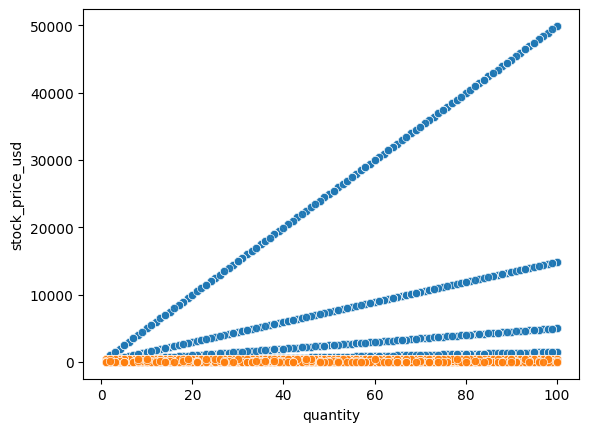

In [23]:
# relationship between the price per 1 license and the quantity
temp_table = sales[(sales['product'] == 'CL') & (sales['license_type'] == 'Renew')]
sns.scatterplot(x=temp_table['quantity'], y=temp_table['stock_price_per_quantity'], alpha = 0.9)
plt.show()

**Note:** the price for 1 license has 4 types - stable regardless of the quantity

Let's see if there is a difference in price by products and license types

In [25]:
# when calculating the price for 1 license, the values ​​were not unified
sales['stock_price_per_quantity_unify'] = sales['stock_price_per_quantity'].apply(lambda x: 15 if x < 15 else (
                                                                                            50 if x < 50 else (
                                                                                                150 if x < 150 else 500)))
sales.stock_price_per_quantity.unique()

array([ 14.9,  49.9,  49.9, 499. , 149. ,  14.9,  14.9])

In [26]:
# by product and license check if there is a difference in the possible price and how purchases are distributed
sales.groupby(['product', 'license_type', 'stock_price_per_quantity_unify']).agg({'customer_id': 'count',
                                                                                  'quantity': ['min', 'mean', 'median','max'],
                                                                                  'date': ['min', 'max']}).style \
                                                        .background_gradient(cmap='RdPu', axis=0, subset = ['customer_id']) \
                                                        .map(lambda x: 'background-color: lightgray' if pd.isnull(x) else '')

**Note**
* all 4 price types are presented in 4 products, and in 2 license types
* distributed evenly
* occur throughout the entire time period

### Dynamic

In [29]:
# to datetime
sales['date'] = pd.to_datetime(sales['date'])

In [30]:
# table with aggregation by months (price descriptive statistic)
sep_month = sales[['date', 'stock_price_usd', 'final_price_usd']].resample('ME', on = 'date').agg({'stock_price_usd': ['min', 'mean', 'max'],
                                                                                       'final_price_usd': ['min', 'mean', 'max']})

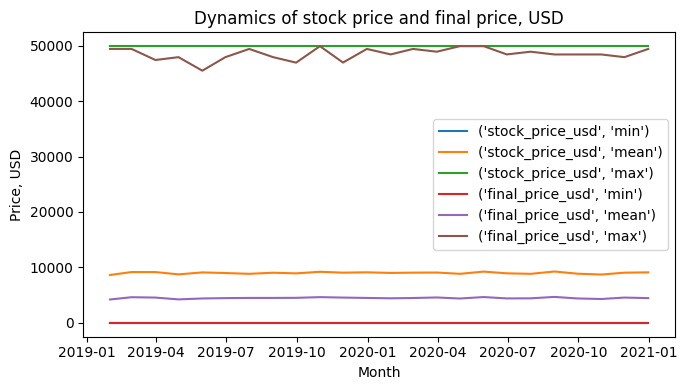

In [31]:
# plot descriptive statistics of price by month
plt.figure(figsize = (7, 4))

col = [('stock_price_usd',  'min'),
            ('stock_price_usd', 'mean'),
            ('stock_price_usd',  'max'),
            ('final_price_usd',  'min'),
            ('final_price_usd', 'mean'),
            ('final_price_usd',  'max')]
plt.plot(sep_month[col])
plt.xlabel('Month')
plt.ylabel('Price, USD')
plt.title('Dynamics of stock price and final price, USD')
plt.legend(col)

plt.tight_layout()
plt.show()

**Note**: The average price with and without a discount remains unchanged over time

**Отрисовка динмики выручки в разрезе продуктов**

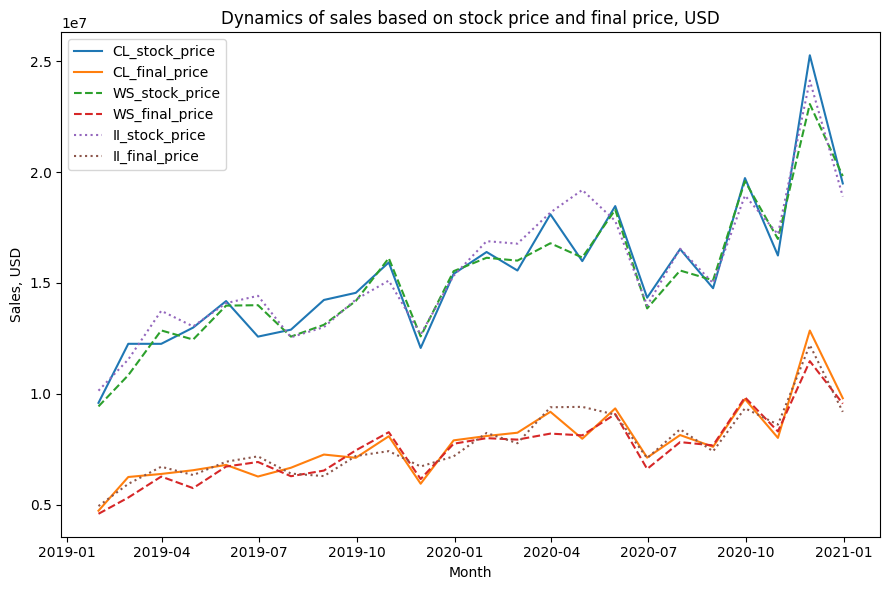

In [34]:
# drawing revenue dynamics by product
cl_month = sales.loc[(sales['product'] == 'CL'), ['date', 'stock_price_usd', 
                                              'final_price_usd']].resample('ME', on = 'date').agg({'stock_price_usd': 'sum',
                                                                                       'final_price_usd': 'sum'})
ws_month = sales.loc[(sales['product'] == 'WS'), ['date', 'stock_price_usd', 
                                              'final_price_usd']].resample('ME', on = 'date').agg({'stock_price_usd': 'sum',
                                                                                       'final_price_usd': 'sum'})
II_month = sales.loc[(sales['product'] == 'II'), ['date', 'stock_price_usd', 
                                              'final_price_usd']].resample('ME', on = 'date').agg({'stock_price_usd': 'sum',
                                                                                       'final_price_usd': 'sum'})
plt.figure(figsize = (9, 6))

col = ['stock_price_usd', 
       'final_price_usd']
plt.plot(cl_month[col], label = ['CL_stock_price', 'CL_final_price'])
plt.plot(ws_month[col], label = ['WS_stock_price', 'WS_final_price'], linestyle = '--')
plt.plot(II_month[col], label = ['II_stock_price', 'II_final_price'], linestyle = ':')

plt.xlabel('Month')
plt.ylabel('Sales, USD')
plt.title('Dynamics of sales based on stock price and final price, USD')
plt.legend()

plt.tight_layout()
plt.show()

**Notes:**
* revenue for 3 products is approximately the same (with and without discount), the same fluctuations from month to month
* upward trend

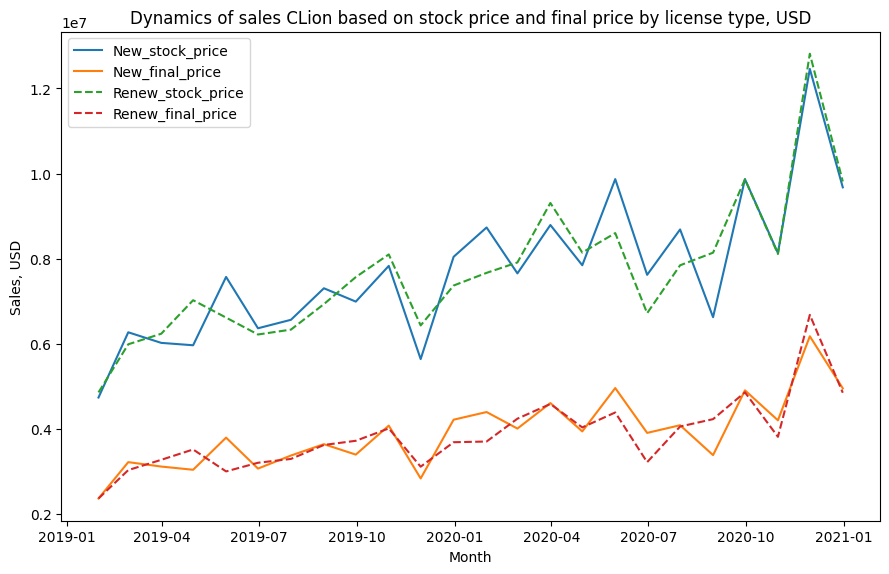

In [36]:
# drawing the dynamics of CL revenue by license*
cl_new_month = sales.loc[(sales['product'] == 'CL') & (sales['license_type'] == 'New'), ['date', 'stock_price_usd', 
                                              'final_price_usd']].resample('ME', on = 'date').agg({'stock_price_usd': 'sum',
                                                                                       'final_price_usd': 'sum'})
cl_renew_month = sales.loc[(sales['product'] == 'CL') & (sales['license_type'] == 'Renew'), ['date', 'stock_price_usd', 
                                              'final_price_usd']].resample('ME', on = 'date').agg({'stock_price_usd': 'sum',
                                                                                       'final_price_usd': 'sum'})
plt.figure(figsize = (9, 6))

col = ['stock_price_usd', 
       'final_price_usd']
plt.plot(cl_new_month[col], label = ['New_stock_price', 'New_final_price'])
plt.plot(cl_renew_month[col], label = ['Renew_stock_price', 'Renew_final_price'], linestyle = '--')

plt.xlabel('Month')
plt.ylabel('Sales, USD')
plt.title('Dynamics of sales CLion based on stock price and final price by license type, USD')
plt.legend()

plt.tight_layout()
plt.show()

**Note**: revenue is approximately the same across licenses, but dynamics may differ by month

**Conclusion**: in the future, the forecast can be built for two licenses simultaneously, because they have the same trend and changes, i.e. the groups are homogeneous.
If there were different trends and different shares in revenue, then 2 separate models would be built.

### Stability

In [39]:
# revenue stability from month to month
sep_month_cl = sales.loc[(sales['product'] == 'CL'), ['date', 
                                                      'stock_price_usd', 
                                                      'final_price_usd',
                                                     'stock_price_per_quantity']].resample('ME', on = 'date').agg({'stock_price_usd': 'sum',
                                                                                                                   'final_price_usd': 'sum'})
#growth rate calculation
sep_month_cl['stock_shift'] = sep_month_cl['stock_price_usd'].shift(1)
sep_month_cl['final_shift'] = sep_month_cl['final_price_usd'].shift(1)
sep_month_cl['stock growth rate'] = (sep_month_cl['stock_price_usd'] / sep_month_cl['stock_shift']) * 100 - 100
sep_month_cl['final growth rate'] = (sep_month_cl['final_price_usd'] / sep_month_cl['final_shift']) * 100 - 100
# descriptive statistics
sep_month_cl.loc['avg'] = sep_month_cl.mean(axis = 0)
sep_month_cl.loc['median'] = sep_month_cl.median(axis = 0)
sep_month_cl.loc['min'] = sep_month_cl.min(axis = 0)
sep_month_cl.loc['max'] = sep_month_cl.max(axis = 0)
sep_month_cl.loc['std'] = sep_month_cl.std(axis = 0)
sep_month_cl.loc['variation_coef'] = sep_month_cl.loc['std'] / sep_month_cl.loc['avg'] * 100

sep_month_cl.style \
        .background_gradient(cmap='RdPu', axis=0) \
        .format('{:.1f}') \
        .map(lambda x: 'background-color: lightgray' if pd.isnull(x) else '')

,stock_price_usd,final_price_usd,stock_shift,final_shift,stock growth rate,final growth rate
date,,,,,,
2019-01-31 00:00:00,9590189.7,4723325.0,nan,nan,nan,nan
2019-02-28 00:00:00,12254844.6,6244907.0,9590189.7,4723325.0,27.8,32.2
2019-03-31 00:00:00,12253743.8,6382660.9,12254844.6,6244907.0,-0.0,2.2
2019-04-30 00:00:00,12985650.9,6550462.6,12253743.8,6382660.9,6.0,2.6
2019-05-31 00:00:00,14183248.8,6790234.9,12985650.9,6550462.6,9.2,3.7
2019-06-30 00:00:00,12579201.9,6266490.4,14183248.8,6790234.9,-11.3,-7.7
2019-07-31 00:00:00,12893145.9,6662768.5,12579201.9,6266490.4,2.5,6.3
2019-08-31 00:00:00,14233520.7,7257741.5,12893145.9,6662768.5,10.4,8.9
2019-09-30 00:00:00,14555238.2,7111309.2,14233520.7,7257741.5,2.3,-2.0


In [40]:
# amount of discount
sep_month_cl.loc['median', 'stock_price_usd']  - sep_month_cl.loc['median', 'final_price_usd']

7657463.005375001

In [41]:
sales

,Unnamed: 0,date,customer_id,product,license_type,quantity,stock_price_usd,final_price_usd,discount_percent,stock_price_per_quantity,stock_price_per_quantity_unify
0,1,2019-01-01,796915.0,WS,New,19,283.1,172.691,39,14.9,15
1,2,2019-01-01,796915.0,CL,Renew,22,1097.8,625.746,43,49.9,50
2,3,2019-01-01,796915.0,CL,Renew,89,4441.1,399.699,91,49.9,50
3,4,2019-01-01,702505.0,CL,New,51,25449.0,12978.990,49,499.0,500
4,5,2019-01-01,702505.0,WS,New,94,14006.0,8263.540,41,149.0,150
...,...,...,...,...,...,...,...,...,...,...,...
123051,123052,2020-12-31,881840.0,CL,New,23,11477.0,1836.320,84,499.0,500
123052,123053,2020-12-31,881840.0,II,Renew,2,29.8,16.688,44,14.9,15
123053,123054,2020-12-31,382597.0,II,New,85,1266.5,873.885,31,14.9,15
123054,123055,2020-12-31,382597.0,WS,Renew,70,34930.0,16766.400,52,499.0,500


**Notes, revenue at the final price:**
* monthly average **growth rate of +5.1%** (from this it follows that the dynamics are positive, on average, revenue grows by 5.1% per month)
* if we look more specifically, **the dynamics** in the month fluctuated **from -26.6%** (November 2019) **to + 60.5%** (November 2020)
* average (median) **revenue per month - 7,751,531** (based on the original price of 15,408,994, the discount amount is 7,657,463)
* **the variation coefficient is 24.6%** (this means that the data is generally homogeneous, but the degree of deviation from the average is considered significant)

In [43]:
# revenue by year
sep_year_cl = sales.loc[(sales['product'] == 'CL'), ['date', 
                                                      'stock_price_usd', 
                                                      'final_price_usd',
                                                     'stock_price_per_quantity',
                                                    'customer_id',
                                                    'quantity']].resample('YE', on = 'date').agg({'stock_price_usd': 'sum',
                                                                                                                   'final_price_usd': 'sum',
                                                                                                                   'customer_id': 'nunique',
                                                                                                                   'quantity': 'sum'})
sep_year_cl['stock_shift'] = sep_year_cl['stock_price_usd'].shift(1)
sep_year_cl['final_shift'] = sep_year_cl['final_price_usd'].shift(1)
sep_year_cl['stock growth rate'] = (sep_year_cl['stock_price_usd'] / sep_year_cl['stock_shift']) * 100 - 100
sep_year_cl['final growth rate'] = (sep_year_cl['final_price_usd'] / sep_year_cl['final_shift']) * 100 - 100
sep_year_cl['sales_per_customer'] = sep_year_cl['final_price_usd'] / sep_year_cl['customer_id']
sep_year_cl['quantity_per_customer'] = sep_year_cl['quantity'] / sep_year_cl['customer_id']
sep_year_cl.loc['avg'] = sep_year_cl.mean(axis = 0)
sep_year_cl.loc['min'] = sep_year_cl.min(axis = 0)
sep_year_cl.loc['max'] = sep_year_cl.max(axis = 0)
sep_year_cl.loc['std'] = sep_year_cl.std(axis = 0)
sep_year_cl.loc['variation_coef'] = sep_year_cl.loc['std'] / sep_month_cl.loc['avg'] * 100

sep_year_cl.style \
        .background_gradient(cmap='RdPu', axis=0) \
        .format('{:.1f}') \
        .map(lambda x: 'background-color: lightgray' if pd.isnull(x) else '')

,stock_price_usd,final_price_usd,customer_id,quantity,stock_shift,final_shift,stock growth rate,final growth rate,sales_per_customer,quantity_per_customer
date,,,,,,,,,,
2019-12-31 00:00:00,158935450.0,79913226.3,12888.0,896313.0,nan,nan,nan,nan,6200.6,69.5
2020-12-31 00:00:00,210880406.6,106123518.2,17067.0,1186967.0,158935450.0,79913226.3,32.7,32.8,6218.1,69.5
avg,184907928.3,93018372.2,14977.5,1041640.0,158935450.0,79913226.3,32.7,32.8,6209.3,69.5
min,158935450.0,79913226.3,12888.0,896313.0,158935450.0,79913226.3,32.7,32.8,6200.6,69.5
max,210880406.6,106123518.2,17067.0,1186967.0,158935450.0,79913226.3,32.7,32.8,6218.1,69.5
std,25972478.3,13105145.9,2089.5,145327.0,0.0,0.0,0.0,0.0,8.7,0.0
variation_coef,168.6,169.1,nan,nan,0.0,0.0,0.0,0.0,nan,nan


In [44]:
# revenue by year
sep_year_cl = sales[['date', 
                                                      'stock_price_usd', 
                                                      'final_price_usd',
                                                     'stock_price_per_quantity',
                                                    'customer_id',
                                                    'quantity']].resample('YE', on = 'date').agg({'stock_price_usd': 'sum',
                                                                                                                   'final_price_usd': 'sum',
                                                                                                                   'customer_id': 'nunique',
                                                                                                                   'quantity': 'sum'})
sep_year_cl.style \
        .background_gradient(cmap='RdPu', axis=0) \
        .format('{:.1f}') \
        .map(lambda x: 'background-color: lightgray' if pd.isnull(x) else '')

,stock_price_usd,final_price_usd,customer_id,quantity
date,,,,
2019-12-31 00:00:00,476503236.8,237089933.2,20893.0,2673035.0
2020-12-31 00:00:00,631826992.9,314833464.3,27721.0,3545964.0


In [45]:
# change in revenue for the year
sep_year_cl.iloc[1, 0]  - sep_year_cl.iloc[0, 0], sep_year_cl.iloc[1, 1]  - sep_year_cl.iloc[0, 1]

(155323756.09999996, 77743531.123)

**Notes:**

* Clion revenue in 2019 - 79,913,226 USD, in 2020 - 106,123,518 USD, **growth by 26,210,291 USD, growth rate- +32.8%**

In [47]:
# table for report
# sep_month_cl.iloc[:24, :]

In [48]:
# sales stability table over time
sales['date_month'] = pd.to_datetime(sales.date).dt.to_period('M')#.dt.to_timestamp()
sales[(sales['product'] == 'CL')].groupby('date_month').apply(lambda x: pd.Series({'Total_cnt': x['customer_id'].count(),
                                                       ## stock price
                                                      'Standart deviation_stock': x['stock_price_usd'].std(),
                                                      'Mean_stock': x['stock_price_usd'].mean(),
                                                      'Coef_var_stock': x['stock_price_usd'].std() / x['stock_price_usd'].mean() * 100,
                                                       ## final price
                                                      'Standart deviation_final': x['final_price_usd'].std(),
                                                      'Mean_final': x['final_price_usd'].mean(),
                                                     'Coef_var_final': x['final_price_usd'].std() / x['final_price_usd'].mean() * 100
                                                      })).style \
                                                         .background_gradient(cmap='RdPu', axis=0, subset = ['Total_cnt', 'Coef_var_stock', 'Coef_var_final']) \
                                                         .format('{:.1f}') \
                                                         .map(lambda x: 'background-color: lightgray' if pd.isnull(x) else '')

,Total_cnt,Standart deviation_stock,Mean_stock,Coef_var_stock,Standart deviation_final,Mean_final,Coef_var_final
date_month,,,,,,,
2019-01,1129.0,11830.5,8494.4,139.3,7033.7,4183.6,168.1
2019-02,1293.0,12595.8,9477.8,132.9,7904.3,4829.8,163.7
2019-03,1393.0,11920.6,8796.7,135.5,7766.2,4582.0,169.5
2019-04,1488.0,12066.6,8726.9,138.3,7427.9,4402.2,168.7
2019-05,1560.0,12189.0,9091.8,134.1,7094.7,4352.7,163.0
2019-06,1485.0,11555.0,8470.8,136.4,7003.9,4219.9,166.0
2019-07,1479.0,12184.7,8717.5,139.8,7995.2,4504.9,177.5
2019-08,1523.0,12617.3,9345.7,135.0,8007.0,4765.4,168.0
2019-09,1652.0,12166.8,8810.7,138.1,7363.3,4304.7,171.1


**Note**: When looking at sales individually, the intra-month variation coefficient is greater than 160, indicating that the data is not uniform. That is, the purchase amount varies greatly from one customer to another.

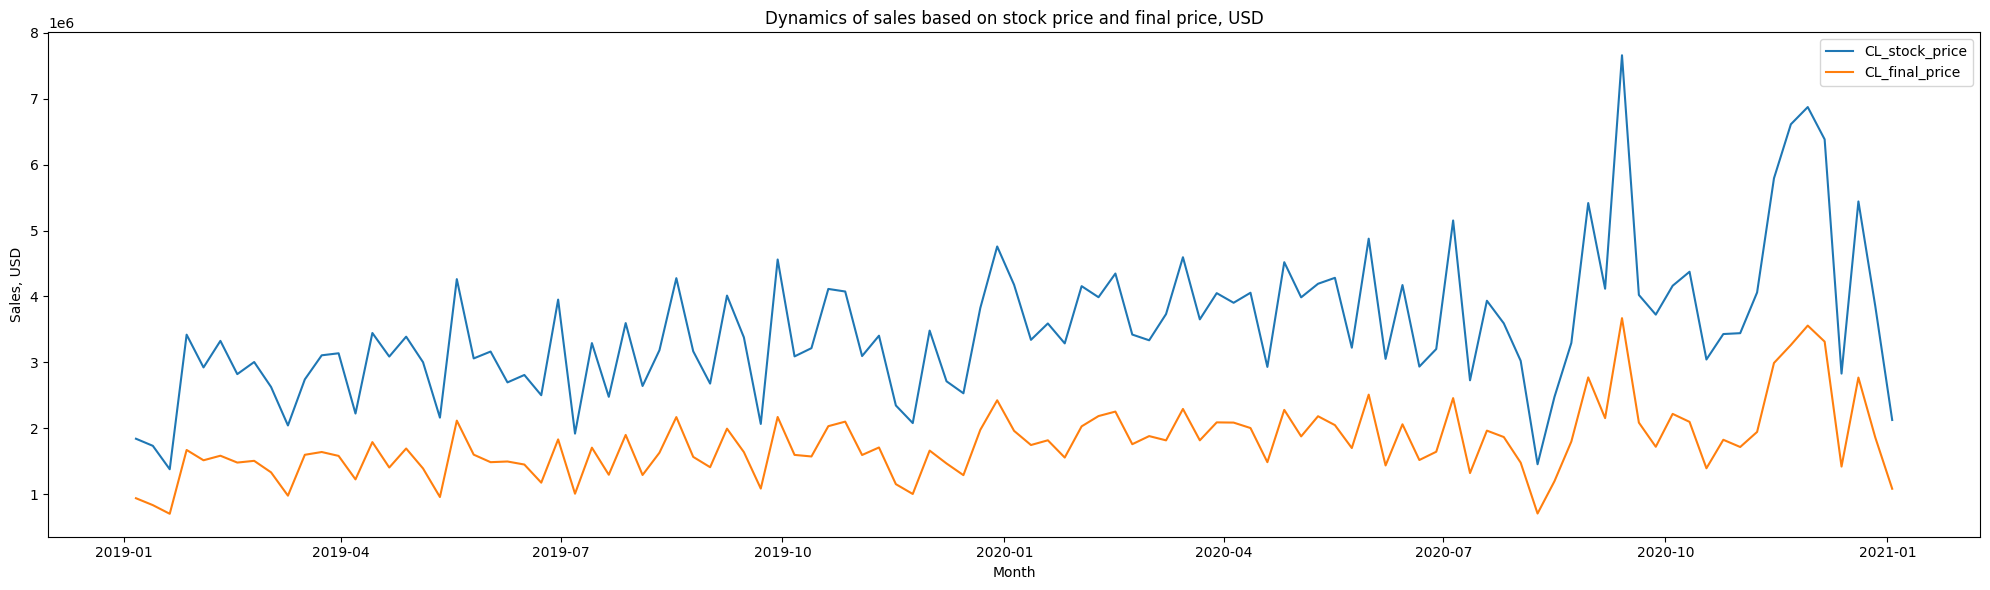

In [50]:
#week sales
cl_month = sales.loc[(sales['product'] == 'CL'), ['date', 'stock_price_usd', 
                                              'final_price_usd']].resample('W', on = 'date').agg({'stock_price_usd': 'sum',
                                                                                       'final_price_usd': 'sum'})
# ws_month = sales.loc[(sales['product'] == 'WS'), ['date', 'stock_price_usd', 
#                                               'final_price_usd']].resample('D', on = 'date').agg({'stock_price_usd': 'sum',
#                                                                                        'final_price_usd': 'sum'})
# II_month = sales.loc[(sales['product'] == 'II'), ['date', 'stock_price_usd', 
#                                               'final_price_usd']].resample('D', on = 'date').agg({'stock_price_usd': 'sum',
                                                                                       # 'final_price_usd': 'sum'})
plt.figure(figsize = (20, 6))

col = ['stock_price_usd', 'final_price_usd']
plt.plot(cl_month[col], label = ['CL_stock_price', 'CL_final_price'])
# plt.plot(ws_month[col], label = ['WS_stock_price', 'WS_final_price'], linestyle = '--')
# plt.plot(II_month[col], label = ['II_stock_price', 'II_final_price'], linestyle = ':')

plt.xlabel('Month')
plt.ylabel('Sales, USD')
plt.title('Dynamics of sales based on stock price and final price, USD')
plt.legend()

plt.tight_layout()
plt.show()

**Note**: After July 2020, there has been strong instability in terms of weeks, both in terms of sales decline and increase.

## Quantity

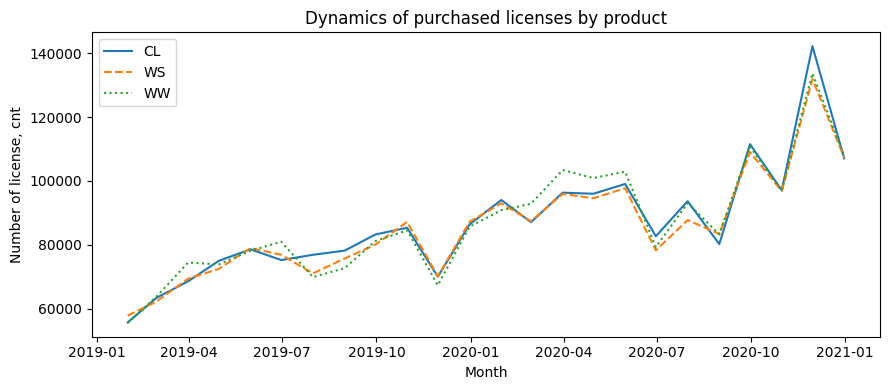

In [53]:
cl_month = sales.loc[(sales['product'] == 'CL'), ['date', 'quantity']].resample('ME', on = 'date').sum()
ws_month = sales.loc[(sales['product'] == 'WS'), ['date', 'quantity']].resample('ME', on = 'date').sum()
II_month = sales.loc[(sales['product'] == 'II'), ['date', 'quantity']].resample('ME', on = 'date').sum()
plt.figure(figsize = (9, 4))

col = ['quantity']
plt.plot(cl_month[col], label = 'CL')
plt.plot(ws_month[col], label = 'WS', linestyle = '--')
plt.plot(II_month[col], label = 'WW', linestyle = ':')

plt.xlabel('Month')
plt.ylabel('Number of license, cnt')
plt.title('Dynamics of purchased licenses by product')
plt.legend()

plt.tight_layout()
plt.show()

**Note**: considering that the price is stable over time, the positive trend is explained by the increase in the number of purchased licenses

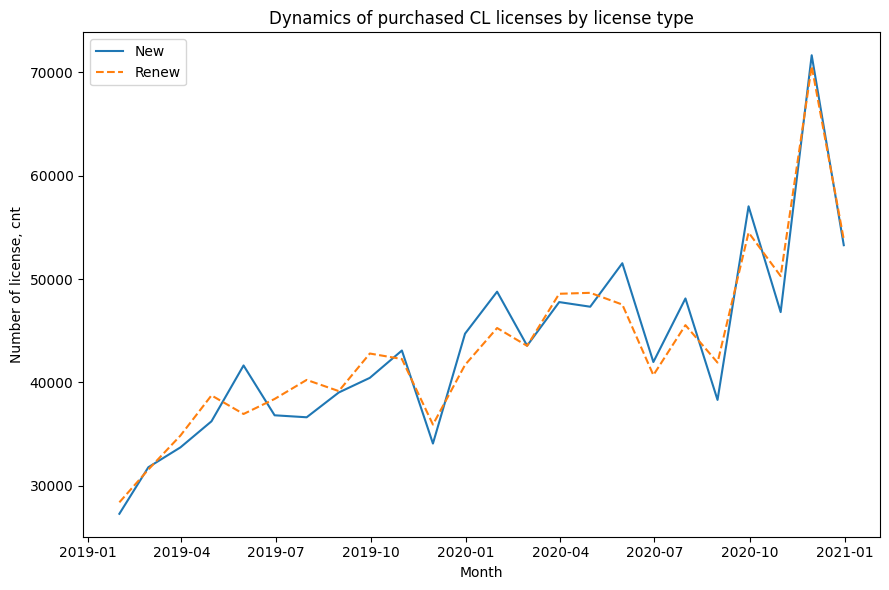

In [55]:
cl_new_month = sales.loc[(sales['product'] == 'CL') & (sales['license_type'] == 'New'),  ['date', 'quantity']].resample('ME', on = 'date').sum()
cl_renew_month = sales.loc[(sales['product'] == 'CL') & (sales['license_type'] == 'Renew'),  ['date', 'quantity']].resample('ME', on = 'date').sum()
plt.figure(figsize = (9, 6))

col = ['quantity']
plt.plot(cl_new_month[col], label = 'New')
plt.plot(cl_renew_month[col], label = 'Renew', linestyle = '--')

plt.xlabel('Month')
plt.ylabel('Number of license, cnt')
plt.title('Dynamics of purchased CL licenses by license type')
plt.legend()

plt.tight_layout()
plt.show()

**Note**: the number of purchases of different types of licenses is the same, the dynamics are the same

## Per client

In [58]:
#are there purchases on different dates (UPD: a little)
temp_clients = sales.groupby(['customer_id'])[['date']].nunique()
temp_clients[temp_clients.date > 1].sort_values('date')

,date
customer_id,
1043.0,2
654580.0,2
655318.0,2
656928.0,2
658025.0,2
...,...
888552.0,3
18908.0,3
822259.0,3


**Conclusion:**

The data from 01.01.2019 to 31.12.2020 on the sale of the CLion product in the context of 2 types of licenses were analyzed.

1. Revenue from CLion has a positive trend (average monthly growth rate at 5%), in 2020 revenue grew by 33%
2. Revenue fluctuates from month to month, the variation coefficient is 25%., which indicates that the data is homogeneous, but the degree of data dispersion is significant
3. Within the current dataset, we can say that revenue from CLion is approximately equal and coincides in dynamics with other WS and II products.
4. In terms of licenses:
* licenses have approximately the same revenue, the dynamics are correlated

<a class="anchor" id="q2"></a>
# 2. Какую выручку ожидать в следующем периоде

**Create dataset based on frequency**

In [62]:
type_of_aggregation = 'M' #W, D

In [63]:
sep_month_cl = sales.loc[(sales['product'] == 'CL'), ['date', 
                                                      'stock_price_usd', 
                                                      'final_price_usd',
                                                     'stock_price_per_quantity']].resample(type_of_aggregation, on = 'date').agg({'stock_price_usd': 'sum',
                                                                                                                   'final_price_usd': 'sum'})

In [64]:
# split data into train test
from sktime.split import temporal_train_test_split
train, test = temporal_train_test_split(sep_month_cl, test_size=0.2)

### Autoregression

#### Check stationarity and variance

Null hypothesis: Non Stationarity exists in the series. 
Alternative Hypothesis: Stationarity exists in the series

In [68]:
print('adf for stock_price: ', adfuller(sep_month_cl['stock_price_usd'])[1],
      '\nadf for final_price: ', adfuller(sep_month_cl['final_price_usd'])[1])

adf for stock_price:  0.9755126033708582 
adf for final_price:  0.9627657227485542


Data is not currently stationary because the ADF test value is above 0.05. Running the KPSS test can help confirm this.

In [70]:
print('kpss for stock_price: ', kpss(sep_month_cl['stock_price_usd'])[1],
      '\nkpss for final_price: ', kpss(sep_month_cl['final_price_usd'])[1])

kpss for stock_price:  0.015866079758901842 
kpss for final_price:  0.016405841484353693


Here the KPSS test also indicates that our data is not stationary becauase the KPSS test result is below 0.05.

**Note**: "If KPSS and ADF agree that the series is non-stationary then we can consider it non-stationary. We'll need to difference the data before passing data to our autoregressive model.""
This indicates that there are changes in the data time (trend, seasonality, white noise)

#### Seasonal_decompose

In [73]:
from statsmodels.tsa.seasonal import seasonal_decompose
pd.options.display.float_format = '{:.4f}'.format

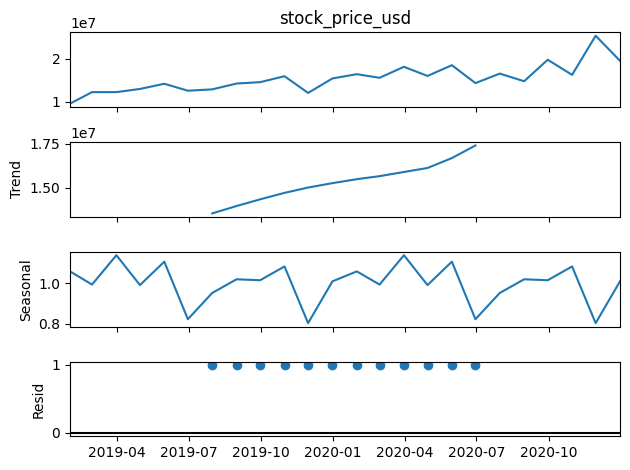

In [74]:
result = seasonal_decompose(sep_month_cl['stock_price_usd'], model='multiplicative')
result.plot()
plt.show()

**Note:** there is a strong trend and seasonality present.

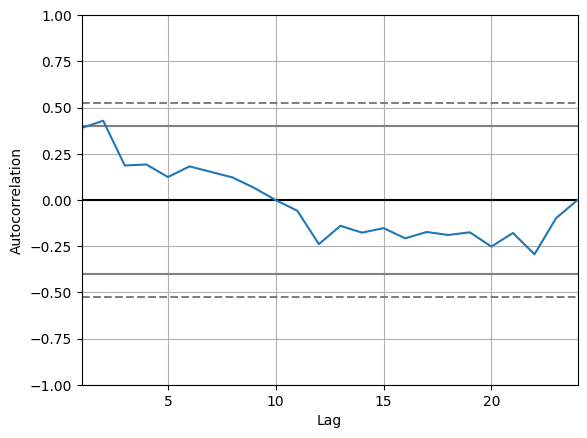

In [76]:
ax = pd.plotting.autocorrelation_plot(sep_month_cl['final_price_usd'])
xydata = ax.lines[-1].get_xydata()
plt.show()
# xydata.astype('float')

**Note**: there is not enough relationship at any level of autocorrelation to use an autoregressive model for forecasting (like ARIMA, SARIMA)

### Clasic time series decompose

In [79]:
from build_model import classic_model

#### Final_price_usd

In [81]:
train_after_fp, test_after_fp = classic_model(train, test, 'M', 'final_price_usd') #final_price_usd, stock_price_usd

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        final_price_usd   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     26.02
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           8.87e-05
Time:                        19:25:05   Log-Likelihood:                -282.91
No. Observations:                  19   AIC:                             569.8
Df Residuals:                      17   BIC:                             571.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.263e+06   1.72e+05     42.256      0.000     6.9e+06    7.63e+06
time        1.601e+05   3.14e+04      5.101      0.000    9.39e+04    2.26e+05
==============================================================================
Omnibus:                        2.269   Durbin-Watson:                   2.330
Prob(Omnibus):                  0.322   Jarque-Bera (JB):                1.524
Skew:                          -0.688   Prob(JB):                        0.467
Kurtosis:                       2.814   Cond. No.                         5.48
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


Metrics after seasonal adjustment


,Classic time series
ME,-36663.5010
MSE,424031267261.5110
MAE,447101.5550
RMSE,651176.8330
MPE,-1.2990
MAPE,6.6160
R2,0.6660



RESULT



'The average monthly revenue (final_price_usd) for the СLion for the first half of 2021 will be: '

10050117

'The product revenue (final_price_usd) in the first half of 2021 will be:: '

60300704

**Note**: It is best when the R-squared is greater than 0.8, but in general 0.666 indicates that the model describes 66.6% of the changes in monthly revenue.

Seasonal adjustment increased the metric from 60,5 to 66,6

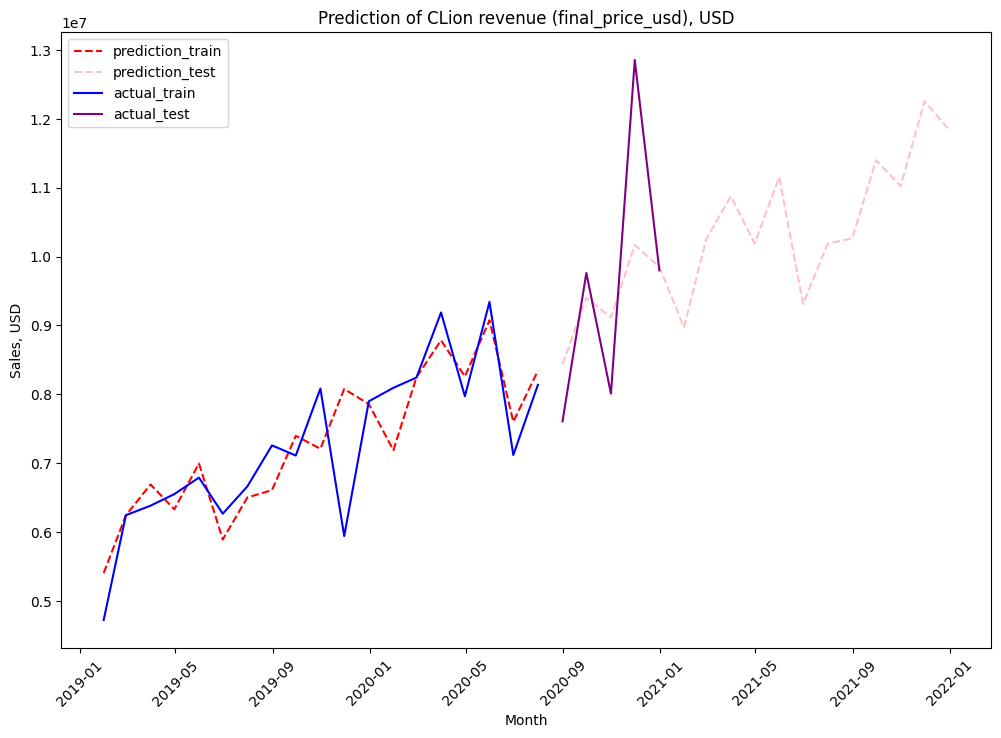

In [83]:
# plot prediction values
plt.figure(figsize = (12, 8))

plt.plot(train_after_fp['predict'], color='red', label='prediction_train', linestyle = '--')
plt.plot(test_after_fp['predict'], color='pink', label='prediction_test', linestyle = '--')
plt.plot(train_after_fp['final_price_usd'], color='blue', label='actual_train')
plt.plot(test_after_fp['final_price_usd'], color='purple', label='actual_test')

plt.xlabel('Month')
plt.ylabel('Sales, USD')
plt.title('Prediction of CLion revenue (final_price_usd), USD')

plt.legend(loc="upper left")
plt.xticks(rotation=45)
plt.show()

#### Stock_price_usd

In [85]:
train_after, test_after = classic_model(train, test, 'M', 'stock_price_usd') #final_price_usd, stock_price_usd

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        stock_price_usd   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     30.11
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           4.01e-05
Time:                        19:25:06   Log-Likelihood:                -294.70
No. Observations:                  19   AIC:                             593.4
Df Residuals:                      17   BIC:                             595.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.444e+07    3.2e+05     45.171      0.000    1.38e+07    1.51e+07
time        3.202e+05   5.84e+04      5.487      0.000    1.97e+05    4.43e+05
==============================================================================
Omnibus:                        1.620   Durbin-Watson:                   2.413
Prob(Omnibus):                  0.445   Jarque-Bera (JB):                1.134
Skew:                          -0.582   Prob(JB):                        0.567
Kurtosis:                       2.721   Cond. No.                         5.48
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


Metrics after seasonal adjustment


,Classic time series
ME,-71632.1270
MSE,1530614812989.0820
MAE,818787.5950
RMSE,1237180.1860
MPE,-1.1810
MAPE,6.1020
R2,0.6820



RESULT



'The average monthly revenue (stock_price_usd) for the СLion for the first half of 2021 will be: '

19868994

'The product revenue (stock_price_usd) in the first half of 2021 will be:: '

119213964

**Note**: R-squared (0.68) indicates that the model describes 68% of the changes in monthly revenue.

Seasonal adjustment increased the metric from 63,9 to 68

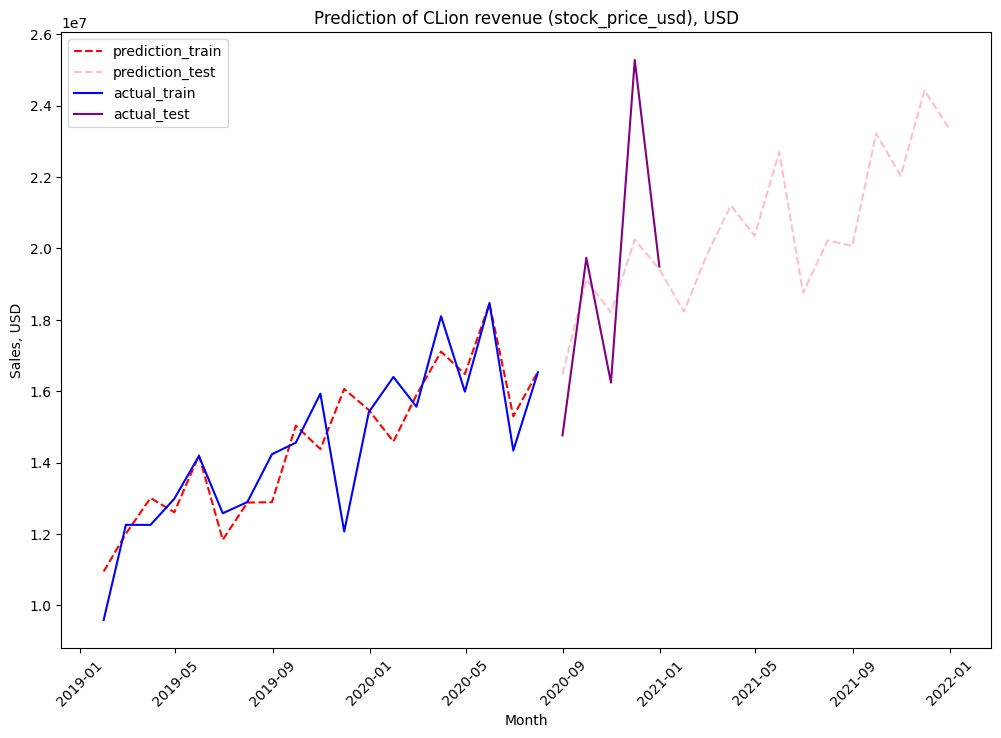

In [87]:
# plot prediction values
plt.figure(figsize = (12, 8))

plt.plot(train_after['predict'], color='red', label='prediction_train', linestyle = '--')
plt.plot(test_after['predict'], color='pink', label='prediction_test', linestyle = '--')
plt.plot(train_after['stock_price_usd'], color='blue', label='actual_train')
plt.plot(test_after['stock_price_usd'], color='purple', label='actual_test')

plt.xlabel('Month')
plt.ylabel('Sales, USD')
plt.title('Prediction of CLion revenue (stock_price_usd), USD')

plt.legend(loc="upper left")
plt.xticks(rotation=45)
plt.show()

### Prophet

#### Monthly

In [90]:
train_prophet = train_after_fp.reset_index()[['date', 'final_price_usd']]
train_prophet.columns = ['ds', 'y']

In [91]:
test_prophet = test_after_fp.reset_index()[['index']]
test_prophet.columns = ['ds']

In [92]:
prophet_model = Prophet(seasonality_mode = 'multiplicative')
prophet_model.fit(train_prophet)

19:25:09 - cmdstanpy - INFO - Chain [1] start processing
19:25:09 - cmdstanpy - INFO - Chain [1] done processing


In [93]:
forecast = prophet_model.predict(test_prophet)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
12,2021-08-31,10777942.0847,9910697.6401,11678200.7617
13,2021-09-30,10935243.5291,10054801.1457,11825211.0284
14,2021-10-31,11097788.3551,10118944.3181,11898587.2454
15,2021-11-30,11255089.7996,10407837.7682,12115001.9127
16,2021-12-31,11417634.6256,10516895.8273,12213002.5508


In [94]:
forecast.loc[5:, 'yhat_lower'].mean()

9644070.482892727

In [95]:
# calculate results
# calculate results
print('The average monthly revenue for the СLion for the first half of 2021 will be: \nlower boundary:', 
      round(forecast.loc[5:, 'yhat_lower'].mean()), 
      '\nupper boundary:', 
      round(forecast.loc[5:, 'yhat_upper'].mean()))

print('\nThe product revenue value in the first half of 2021 will be: \nlower boundary:', 
      round(forecast.loc[5:10, 'yhat_lower'].sum()), 
      '\nupper boundary:', 
      round(forecast.loc[5:10, 'yhat_upper'].sum()))

The average monthly revenue for the СLion for the first half of 2021 will be: 
lower boundary: 9644070 
upper boundary: 11411221

The product revenue value in the first half of 2021 will be: 
lower boundary: 54979377 
upper boundary: 65726638


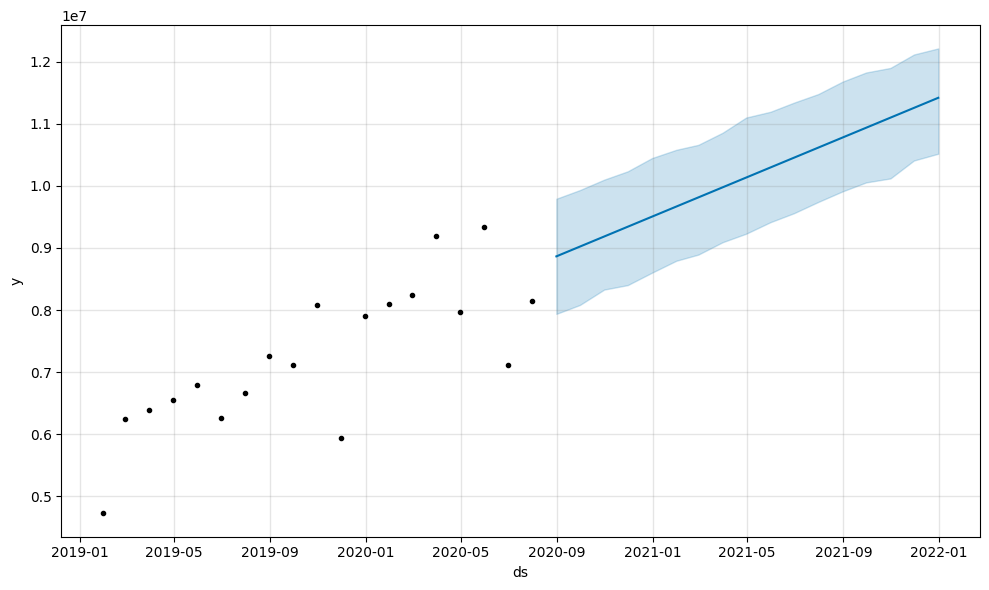

In [96]:
prophet_model.plot(forecast)
plt.show()

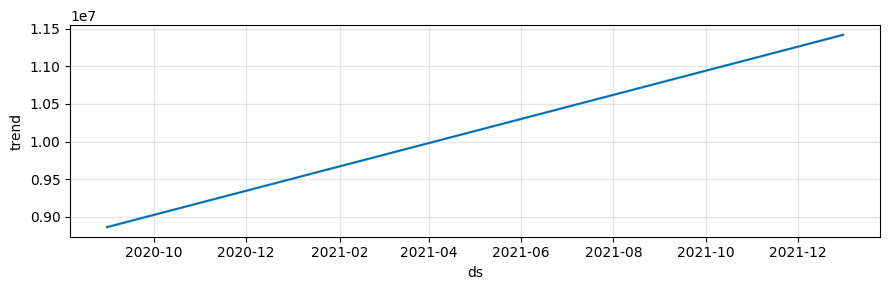

In [97]:
prophet_model.plot_components(forecast)

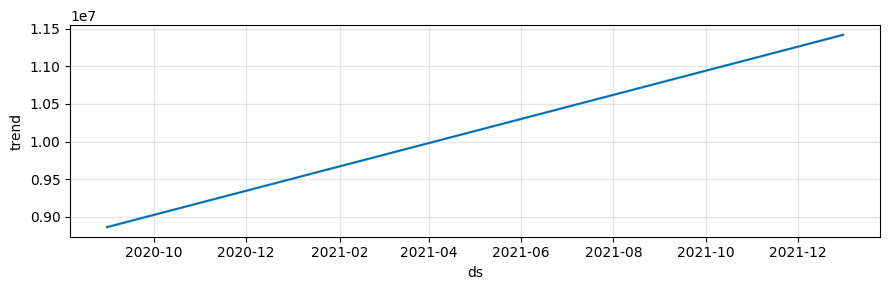

In [98]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(prophet_model, forecast)
plt.show()

#### Dayly

In [100]:
sep_day_cl = sales.loc[(sales['product'] == 'CL'), ['date', 
                                                      'stock_price_usd', 
                                                      'final_price_usd',
                                                     'stock_price_per_quantity']].resample('D', on = 'date').agg({'stock_price_usd': 'sum',
                                                                                                                   'final_price_usd': 'sum'})
sep_day_cl.head()

,stock_price_usd,final_price_usd
date,,
2019-01-01,177447.4000,54505.6000
2019-01-02,605340.0000,284996.4360
2019-01-03,438570.2000,266786.8630
2019-01-04,417917.9000,222904.8110
2019-01-05,137049.8000,78758.9860


In [101]:
# split into train test
train, test = temporal_train_test_split(sep_day_cl, test_size=0.2)

In [102]:
train_prophet = train.reset_index()[['date', 'stock_price_usd']]
train_prophet.columns = ['ds', 'y']

In [103]:
test_prophet = test.reset_index()[['date']]
test_prophet.columns = ['ds']

In [104]:
prophet_model = Prophet()
prophet_model.fit(train_prophet)

19:25:13 - cmdstanpy - INFO - Chain [1] start processing
19:25:13 - cmdstanpy - INFO - Chain [1] done processing


In [105]:
forecast = prophet_model.predict(test_prophet)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
142,2020-12-27,605118.9741,245862.2774,988184.8404
143,2020-12-28,616622.7460,221585.8869,973946.0520
144,2020-12-29,606128.0727,232544.4627,956570.6183
145,2020-12-30,586509.0026,218842.2753,940247.9107
146,2020-12-31,594374.2603,227391.2891,963091.5247


In [106]:
# forecast.loc[5:10]

In [107]:
# # calculate results
# # calculate results
# print('The average monthly revenue for the СLion for the first half of 2021 will be: \nlower boundary:', 
#       round(forecast.loc[5:, 'yhat_lower'].mean()), 
#       '\nupper boundary:', 
#       round(forecast.loc[5:, 'yhat_upper'].mean()))

# print('\nThe product revenue value in the first half of 2021 will be: \nlower boundary:', 
#       round(forecast.loc[5:10, 'yhat_lower'].sum()), 
#       '\nupper boundary:', 
#       round(forecast.loc[5:10, 'yhat_upper'].sum()))

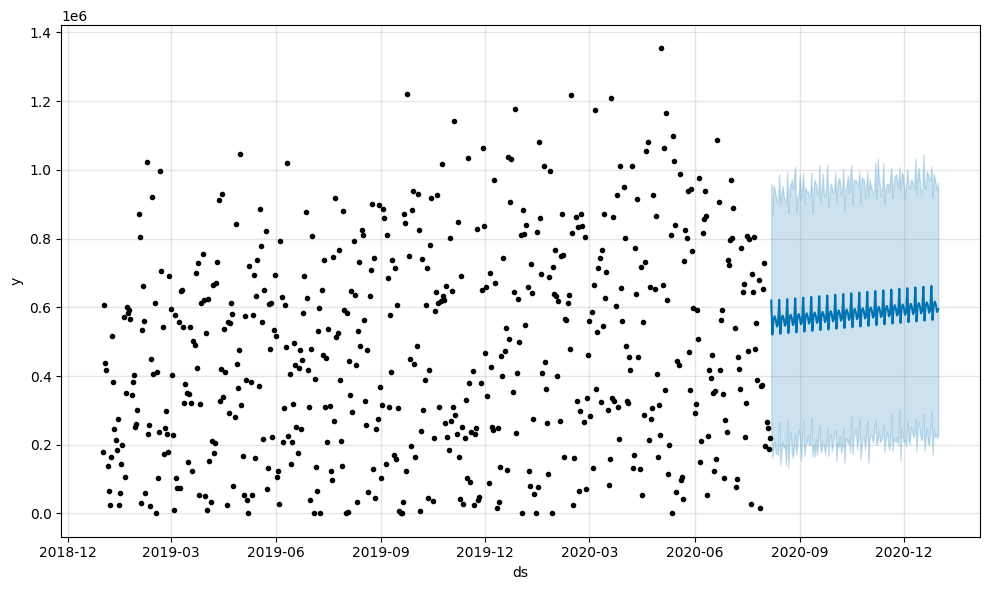

In [108]:
prophet_model.plot(forecast)
plt.show()

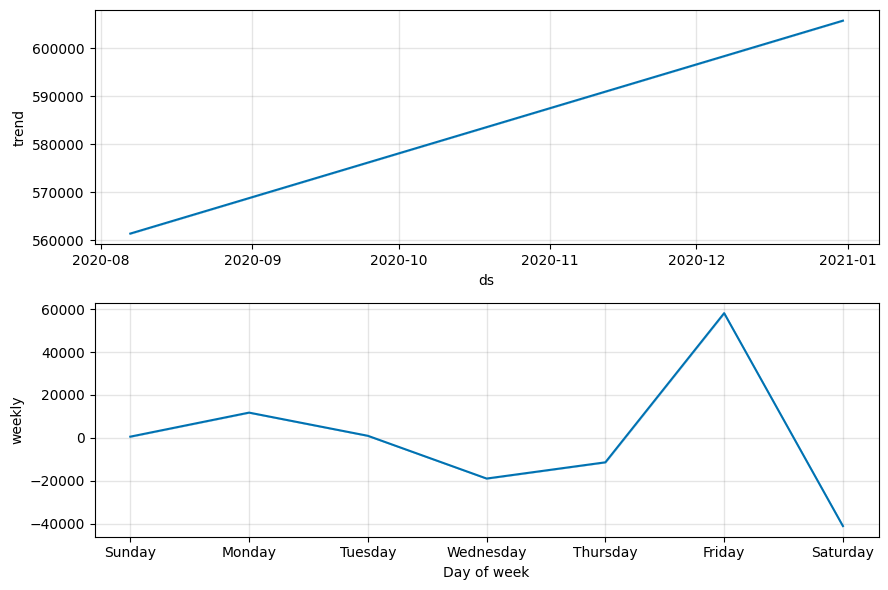

In [109]:
prophet_model.plot_components(forecast)
plt.show()

In [110]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(prophet_model, forecast)
plt.show()

<a class="anchor" id="q3"></a>
# 3. Какие тренды среди разработчиков наблюдаются сейчас
2022 - 2023

1. Estimate how many answers to a question are considered adequate
2. Analyze programming languages
3. Descriptive statistics of C++ programmers (2023 sample)
4. Calculate significant differences in answers between 22 and 23 (chi-square homogeneity/scipy.stats.chisquare)
Display questions where answers changed significantly
5. Identify questions with prevailing answers > 60%
6. Analyze by selected questions

**Upload 2022, 2023 data**

In [114]:
wide = pd.read_csv('data/question/2023/2023_sharing_data_outside.csv', low_memory=False)
narrow = pd.read_csv('data/question/2023/2023_sharing_data_outside_narrow.csv', low_memory=False)
tag = pd.read_csv('data/question/2023/DevEcosystem 2023 questions_outside.csv')

In [115]:
narrow['tag'] = narrow['title'].apply(lambda x: x.split(':')[0])

In [116]:
wide_22 = pd.read_csv('data/question/2022/DevEcosystem_2022_sharing_data.csv', low_memory=False)
narrow_22 = pd.read_csv('data/question/2022/DevEcosystem_2022_sharing_data_narrow.csv', low_memory=False)
tag_22 = pd.read_excel('data/question/2022/DevEcosystem 2022 short names.xlsx')

In [117]:
# unify column name
narrow_22.rename(columns = {'value': 'answer'}, inplace = True)

In [118]:
narrow_22['tag'] = narrow_22['variable'].apply(lambda x: x.split('.')[0])

In [119]:
# similar questions for 22 and 23
tag_common = list(set(tag.shortname.values) & set(tag_22.shortname.values))

In [120]:
# fill nan answers
narrow.fillna({'answer': 'no_choose'}, inplace = True)
narrow_22.fillna({'answer': 'no_choose'}, inplace = True)

In [121]:
# for info: count of response 
cnt_resp_23 = narrow.groupby('tag')[['response_id']].nunique()
cnt_resp_23.columns = ['cnt_all_resp_on_question_23']
narrow = narrow.merge(cnt_resp_23, left_on = 'tag', right_index = True, how = 'left')

In [122]:
# for info: count of response 
cnt_resp_22 = narrow_22.groupby('tag')[['response_id']].nunique()
cnt_resp_22.columns = ['cnt_all_resp_on_question_22']
narrow_22 = narrow_22.merge(cnt_resp_22, left_on = 'tag', right_index = True, how = 'left')

#### Calculate the size of responses for significant analysis

In [124]:
# размер выборки
sample_size = narrow.response_id.nunique()
# доверительная вероятность = 0,95
probab = 0.95
probab_9 = 0.99
selection_bias = 0.01 #max 4
z = 1.96 #if probab = 0.95
z_9 = 2.33
calculate_size_2 = (z_9*z_9*0.5*0.5) / (selection_bias*selection_bias)
selection_bias = 0.04
calculate_size_4 = (z*z*0.5*0.5) / (selection_bias*selection_bias)
print('Actual sample size: ', sample_size, 
      '\nApproximate sampling level that should be achieved with a large population, sampling error of 1%, and confidence level of 0.99:', round(calculate_size_2),
     '\nApproximate sampling level that should be achieved with a large population, sampling error of 4%, and confidence level of 0.9:', round(calculate_size_4),)

Actual sample size:  26348 
Approximate sampling level that should be achieved with a large population, sampling error of 1%, and confidence level of 0.99: 13572 
Approximate sampling level that should be achieved with a large population, sampling error of 4%, and confidence level of 0.9: 600


**Note**: Minimum number of responses per question = 600 for adequate assessment, calculated with the lowest confidence level and the highest acceptable sampling error

### Analyze programming languages

In [127]:
with pd.option_context('display.max_colwidth', None):
    display(tag[tag.shortname.isin(['proglang', 'primary_proglang'])])


,shortname,parent_shortname,question_title,type
27,proglang,NaN,What programming languages have you used in the last 12 months?,CHECKBOX
28,primary_proglang,NaN,"What are your primary programming languages? [question(""title""), id=""506""]",CHECKBOX


In [128]:
progr_lang_col = ['proglang', #programm language last 12m
                    'primary_proglang',# primary programm language
                  'adopt_proglang'] # change to programm language

In [129]:
def cnt_cpp_users(df, progr_lang_col, cnt_column_name):
    #cnt_column_name == cnt_all_resp_on_question_23, cnt_all_resp_on_question_22
    # where C++ is mentioned at least once
    temp = df.loc[(df.answer == 'C++') & (df.tag.isin(progr_lang_col))].groupby('tag').agg({'response_id': 'nunique',
                                                                                            cnt_column_name : 'min'})
    temp['share'] = temp['response_id'] / temp[cnt_column_name] *100
    temp['only_cpp'] = 0

    #list of id chosen C++
    prolang = df.loc[(df.tag == 'proglang') & (df.answer == 'C++'), 'response_id'].unique()
    primary_proglang = df.loc[(df.tag == 'primary_proglang') & (df.answer == 'C++'), 'response_id'].unique()
    adopt_proglang = df.loc[(df.tag == 'adopt_proglang') & (df.answer == 'C++'), 'response_id'].unique()

    # calc also other language
    temp1 = df[(df.tag.isin(['proglang'])) & (df.response_id.isin(prolang))].groupby(['tag', 'response_id'])[['answer']].agg({'answer':'nunique'})
    temp2 = df[(df.tag.isin(['primary_proglang'])) & (df.response_id.isin(primary_proglang))].groupby(['tag', 'response_id'])[['answer']].agg({'answer':'nunique'})
    temp3 = df[(df.tag.isin(['adopt_proglang'])) & (df.response_id.isin(adopt_proglang))].groupby(['tag', 'response_id'])[['answer']].agg({'answer':'nunique'})

    #write  
    temp.loc['proglang', 'only_cpp'] = temp1[temp1.answer == 1].count().iloc[0]
    temp.loc['primary_proglang', 'only_cpp'] = temp2[temp2.answer == 1].count().iloc[0]
    temp.loc['adopt_proglang', 'only_cpp'] = temp3[temp3.answer == 1].count().iloc[0]

    temp['only_cpp_share'] = temp['only_cpp'] / temp['response_id'] * 100
    return prolang, temp

In [130]:
prolang_23, temp_23 = cnt_cpp_users(narrow, progr_lang_col, 'cnt_all_resp_on_question_23')
temp_23

,response_id,cnt_all_resp_on_question_23,share,only_cpp,only_cpp_share
tag,,,,,
adopt_proglang,950,26231,3.6217,175,18.4211
primary_proglang,2572,25049,10.2679,278,10.8087
proglang,5809,26348,22.0472,78,1.3427


**Note**
By C++ usage:

10,3% of respondents had C++ as their primary programming language,

22,0% of respondents had used it in the last 12 months, and

3,6% of respondents were planning to learn it.Only 1.3% of respondents had written exclusively in C++ in the last 12 months, the remaining 98,7% combined it with other programming languages

We will identify C++ programmers who have used it in the last 12 months

In [132]:
prolang_22, temp_22 = cnt_cpp_users(narrow_22, progr_lang_col, 'cnt_all_resp_on_question_22')
temp_22

,response_id,cnt_all_resp_on_question_22,share,only_cpp,only_cpp_share
tag,,,,,
adopt_proglang,636,16355,3.8887,132,20.7547
primary_proglang,2752,27840,9.8851,271,9.8474
proglang,6417,29269,21.9242,59,0.9194


**Note**: C++ usage share hasn't changed much since 2022

### Descriptive statistics of C++ programmers (2023 sample)

In [135]:
# for info: count of c++ programmers response 
cnt_cpp_resp_23 = narrow[narrow.response_id.isin(prolang_23)].groupby('tag')[['response_id']].nunique()
cnt_cpp_resp_23.columns = ['cnt_all_cpp_resp_on_question_23']
narrow = narrow.merge(cnt_cpp_resp_23, left_on = 'tag', right_index = True, how = 'left')

# 2022
cnt_cpp_resp_22 = narrow_22[narrow_22.response_id.isin(prolang_22)].groupby('tag')[['response_id']].nunique()
cnt_cpp_resp_22.columns = ['cnt_all_cpp_resp_on_question_22']
narrow_22 = narrow_22.merge(cnt_cpp_resp_22, left_on = 'tag', right_index = True, how = 'left')

In [136]:
# quick analysis
about_respondents = ['employment_status', 'position_level',
                     'activities_kinds', 'code_yrs',
                     'age_range', 'country',
                     'gender', 'edu_level',
                     'company_size', 'sw_types_developed', 'salary_group',]

cpp_list = ['cpp_standart', 'cpp_move_98', 'cpp_move_11', 'cpp_move_14', 'cpp_move_17', 'cpp_features', 'cpp_cli', 'cpp_ide']

to_think_about = ['salary_satisfied'
                     'ps_productivity_tools', 'ps_familiar',
                     'job_satisfied', 'job_important',
                     'job_meetings', 'job_burnout',
                     'born_here', 'born_country',
                     'job_find', 'language_work',
                     'languages_family', 'communication_tools',
                    'mcrsrvc_do', 'mobile_ndevs_ios_andoid',
                    'docker_familiar', 'rm_ever',
                    'pairprog_tools_remote', 'help_do',
                    'help_howdo', 'dev_toolops',
                    'ds_what', 'lifestyle_code_on_weekends']

tools = ['agile_framework', 'target_platforms1', 'db', 'ides', 'ide_main', 
         'sql_tool', 'devops_containers', 'cloud_services_most',
        'game_lang', 'static_dashboards', 'contribute_os', 'doc_tests', 'ai_tool_types', 'ai_what_tools_use',
        'ai_tools_experience', 'ai_assistants', 'ai_simple_difficult']

jetbrains = ['know_jb', 'jb_prod_use', 'jb_prod_exp', 'ide_personalized_exp', 'kotlin_jb_libraries']

changes = ['adopt_proglang', 'proglang_rank', 'edu_switched_to_it', 'learn_pl', 'learn_why', 'learn_time' ]

In [137]:
def describe_programmers(df, tags, cnt_column_name_cpp, cnt_column_name, list_id):
    #calc all
    temp_all = df[df.tag.isin(tags)].groupby(['tag', 'answer'])[['response_id', cnt_column_name]].agg({'response_id': 'nunique',
                                                                                                                   cnt_column_name : 'min'})
    temp_all['share_all'] = temp_all['response_id'] / temp_all[cnt_column_name] * 100

    #calc only cpp
    temp_cpp = df[(df.tag.isin(tags)) &
                  (df.response_id.isin(list_id))].groupby(['tag', 'answer'])[['response_id', cnt_column_name_cpp]].agg({'response_id': 'nunique',
                                                                                                                   cnt_column_name_cpp : 'min'})
    temp_cpp['share_cpp'] = temp_cpp['response_id'] / temp_cpp[cnt_column_name_cpp] * 100

    temp = temp_cpp.merge(temp_all['share_all'], left_index = True, right_index = True)
    temp['diff_in_share'] = temp['share_cpp'] - temp['share_all']

    return temp

#### about

In [139]:
about = describe_programmers(narrow, about_respondents, 'cnt_all_cpp_resp_on_question_23', 'cnt_all_resp_on_question_23', prolang_23)
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(about.style \
            .background_gradient(cmap='RdPu', axis=0, subset = ['response_id', 'share_cpp', 'diff_in_share']) \
            .format('{:.1f}') \
            .map(lambda x: 'background-color: lightgray' if pd.isnull(x) else ''))

 **Notes**:
Respondents using C++:
* mostly aged 21-29 (47.7%),
* mostly male (91.8%),
* 44.3% have been programming for 1-5 years,
* mostly fully employed (48.9%) or students (37.5%),
* the majority of respondents are from China (11.3%), the US (11.2%), Germany (7.7%), India (6.3%),
* 37.6% have a bachelor's degree,
* 25.9% work for mid-size companies (51-500)
* and are involved in developing: Websites(44%), Utilities (small apps for small tasks) (42.3%), System Software (30.1%), Database / Data Storage(29.5%)

In [141]:
about = about.reset_index()

In [142]:
about_respondents.remove('country')

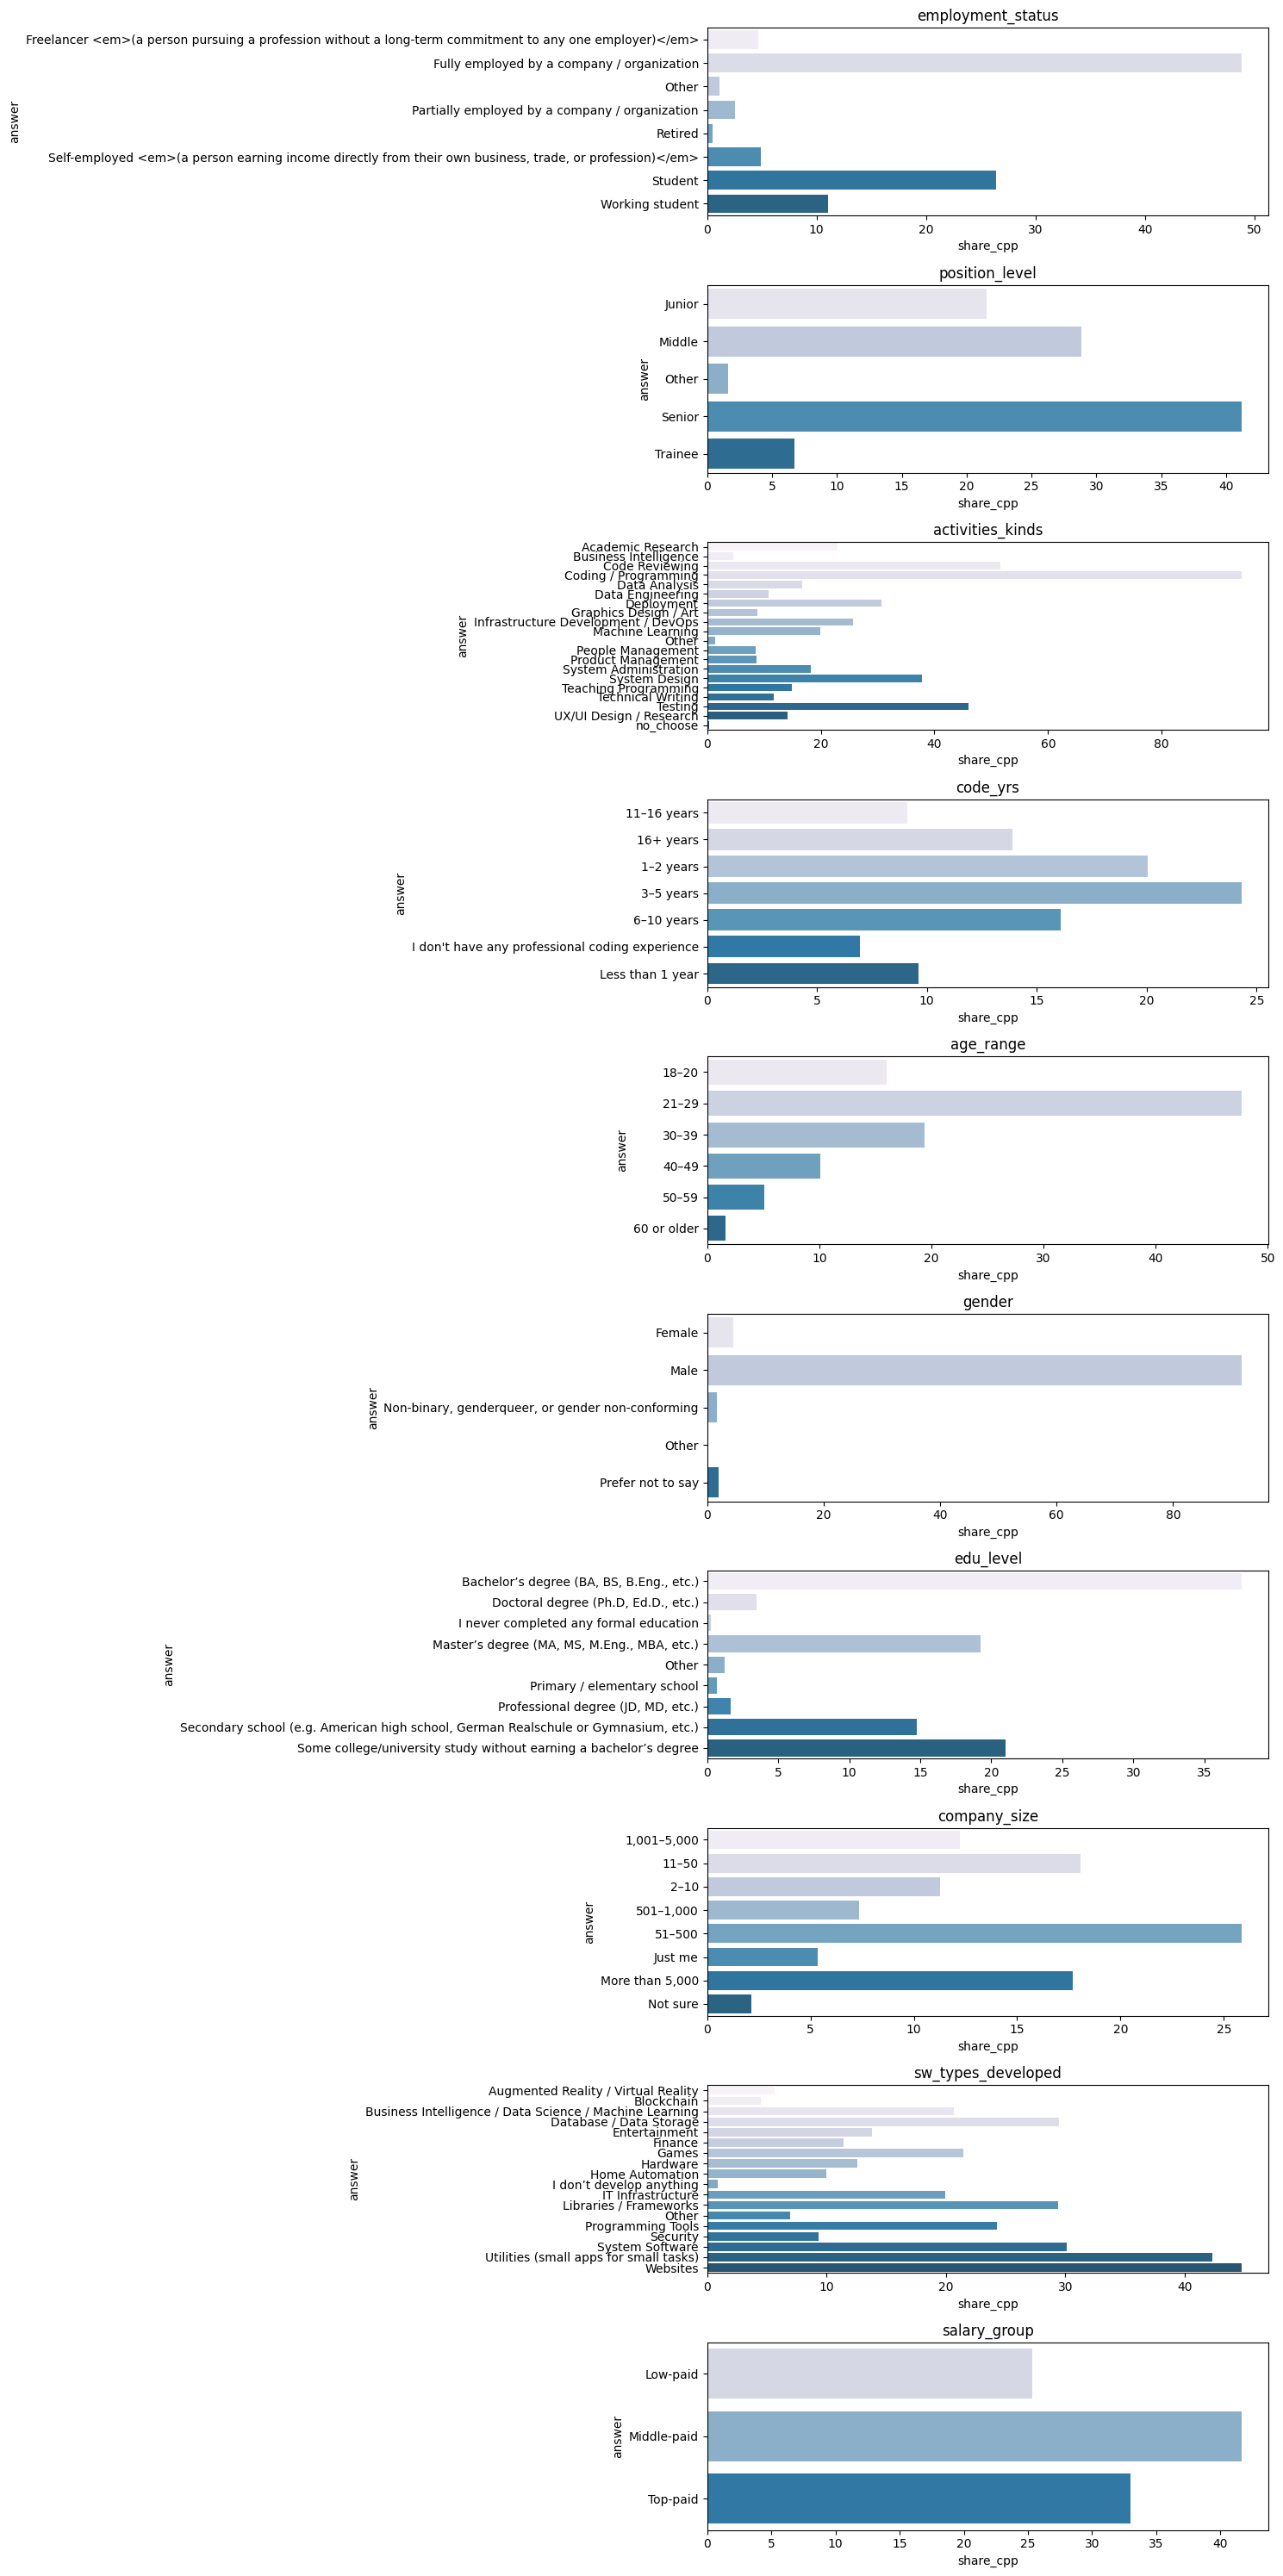

In [143]:
fig, axes = plt.subplots(10, 1, figsize=(15,30), squeeze=False)

for i, ax in zip(about_respondents, axes.ravel()):
    sns.barplot(data=about[about.tag == i], y='answer', x = 'share_cpp', alpha = 0.9, ax=ax, palette="PuBu")
    ax.set_title(i)
    # plt.xlabel(i, fontsize=12)
   
    plt.tight_layout()  
plt.show()

#### c++

In [145]:
cpp = describe_programmers(narrow, cpp_list, 'cnt_all_cpp_resp_on_question_23', 'cnt_all_resp_on_question_23', prolang_23)
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(cpp.style \
            .background_gradient(cmap='RdPu', axis=0, subset = ['response_id', 'share_cpp', 'diff_in_share']) \
            .format('{:.1f}') \
            .map(lambda x: 'background-color: lightgray' if pd.isnull(x) else ''))

 **Notes**:
Respondents using C++:
* Equal proportions of respondents said they use and do not use C++/CLI
* In the next 12 months 52.6% of respondents will use C++20 concepts (template constraints, requires, etc.), 46.8% will use C++20 modules (export, import, etc.)
* 46.9% use C++17 standard, 34.0 - C++20, also popular C++11 and C++14
* those who use C++17 37.1% want to move to C++20
* a big part of the C++98 users (46.3%) do not want to move to a higher standard, others prefer to move to C++17, C++20. Same preferences we can see in C++14, C++11 sers


In [147]:
cpp = cpp.reset_index()

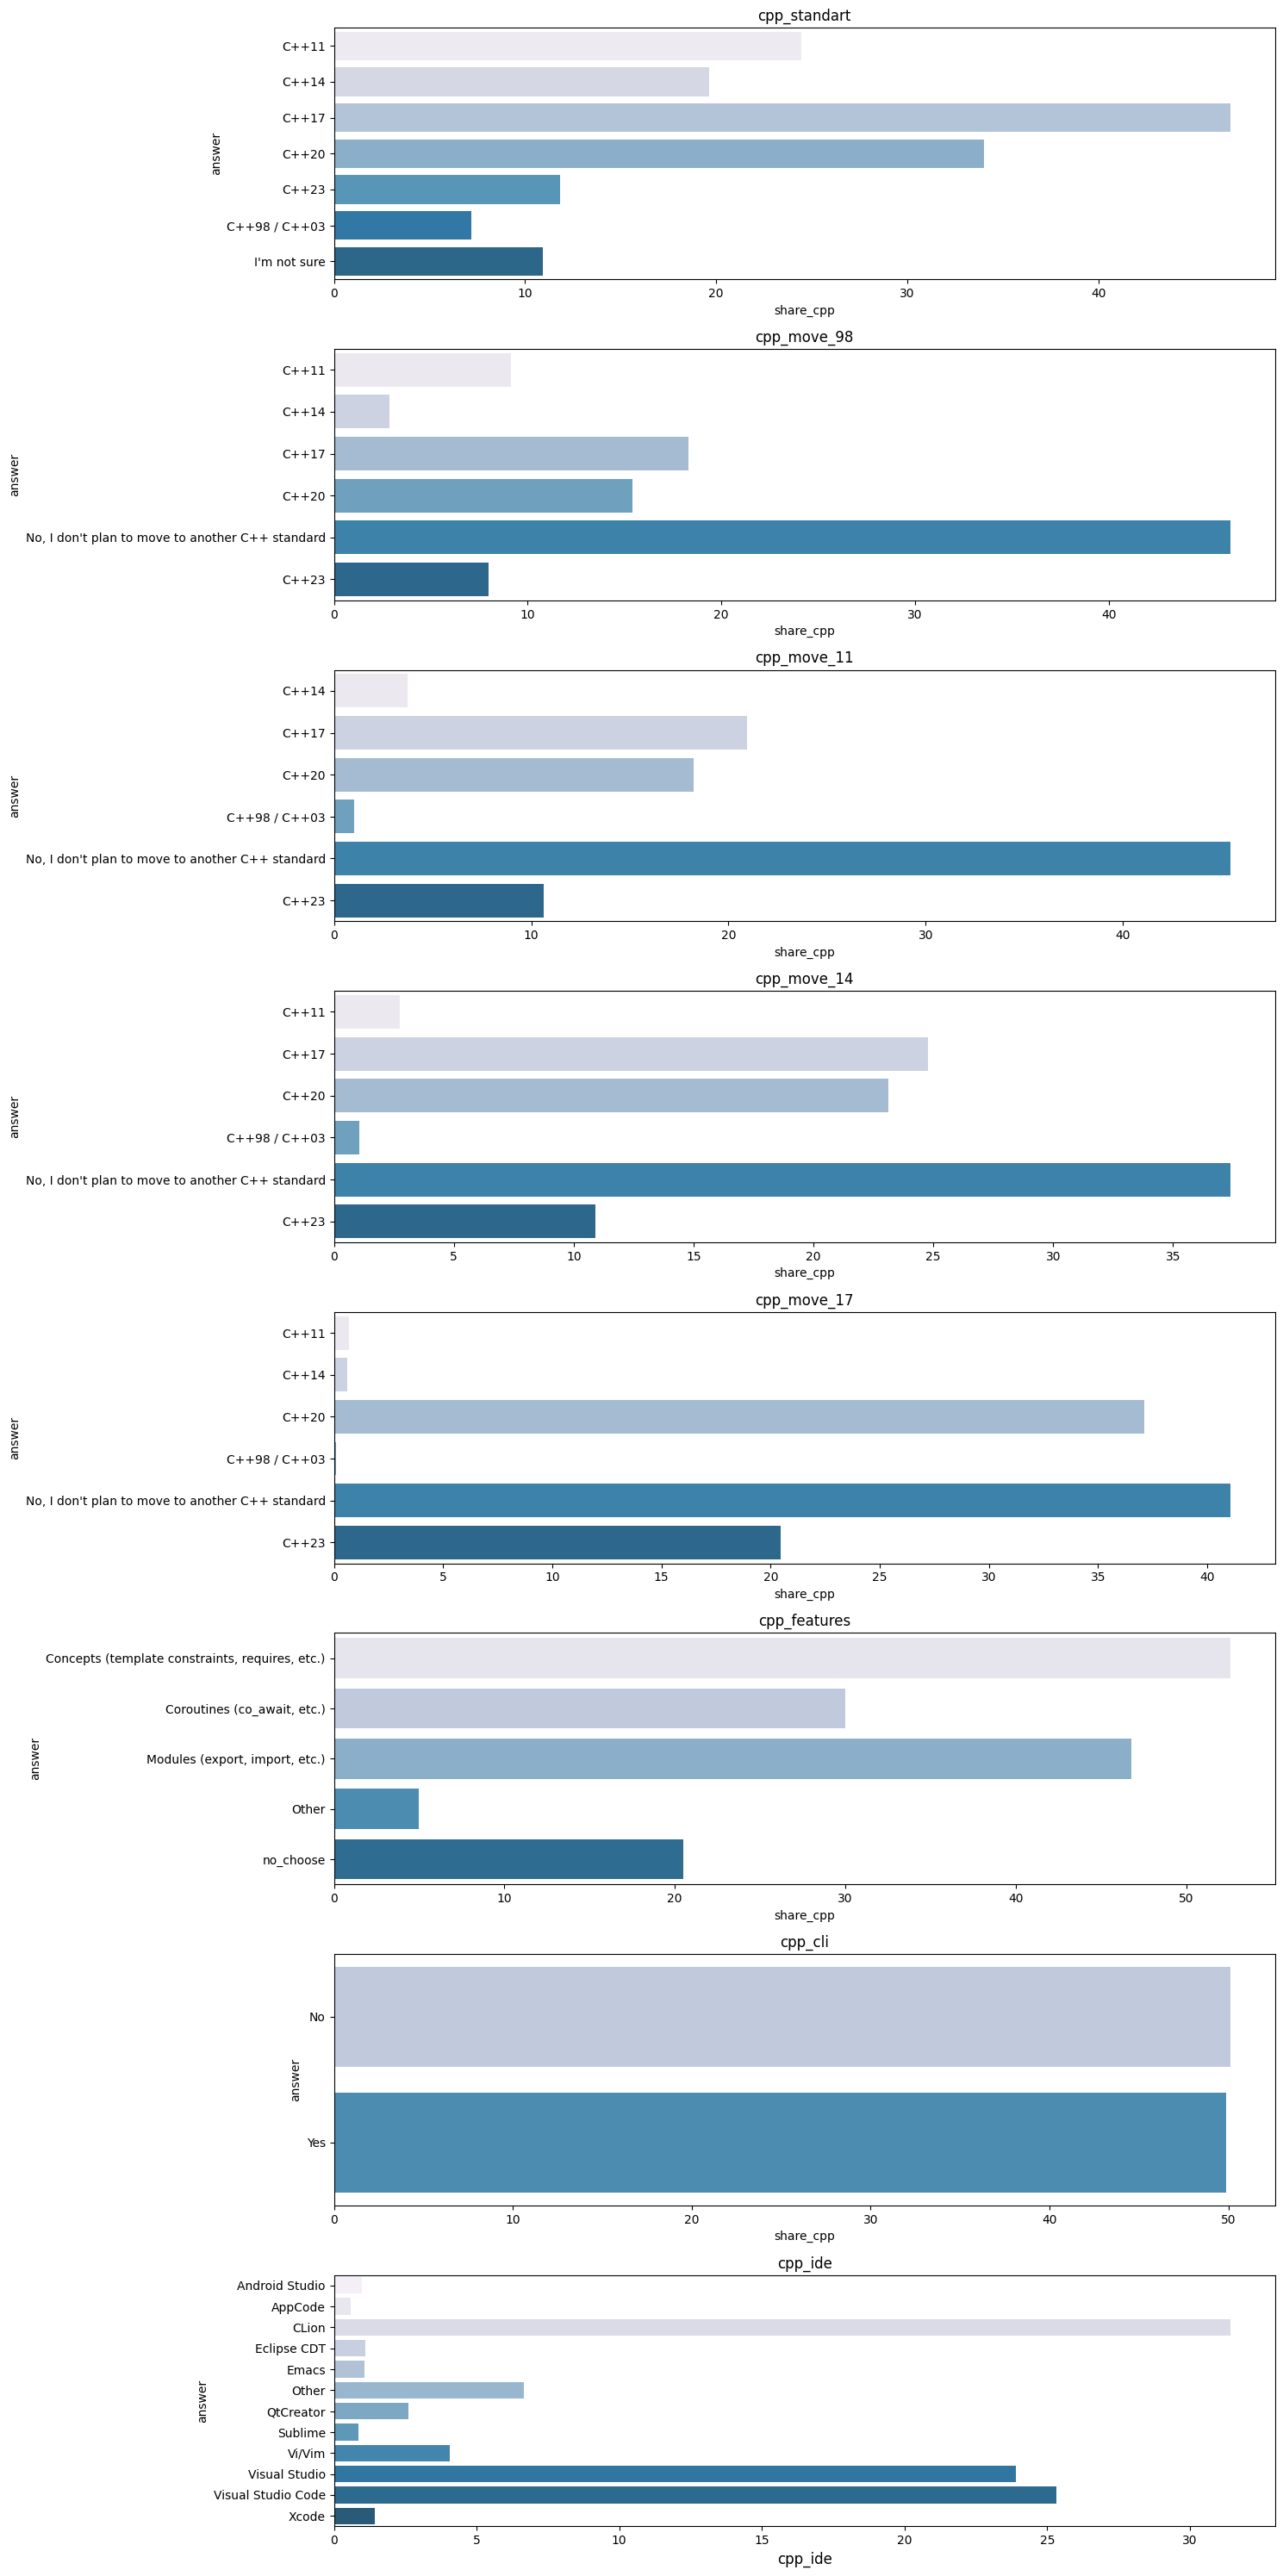

In [148]:
fig, axes = plt.subplots(8, 1, figsize=(15,30), squeeze=False)

for i, ax in zip(cpp_list, axes.ravel()):
    sns.barplot(data=cpp[cpp.tag == i], y='answer', x = 'share_cpp', alpha = 0.9, ax=ax, palette="PuBu")
    ax.set_title(i)
    plt.xlabel(i, fontsize=12)
   
    plt.tight_layout()
plt.show()

#### c++ ide

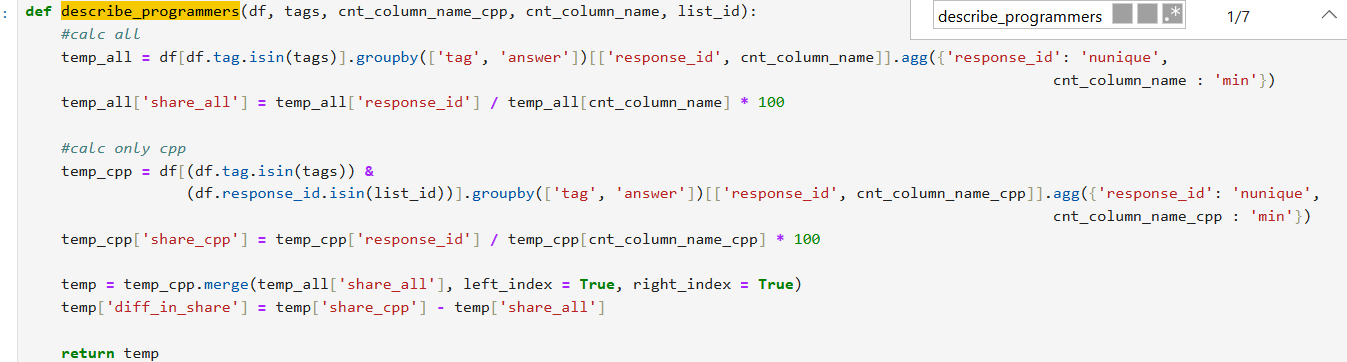

In [151]:
ide_22 = describe_programmers(narrow_22, ['cpp_ide'], 'cnt_all_cpp_resp_on_question_22', 'cnt_all_resp_on_question_22', prolang_22)
ide_23 = describe_programmers(narrow, ['cpp_ide'], 'cnt_all_cpp_resp_on_question_23', 'cnt_all_resp_on_question_23', prolang_23)

In [152]:
ide_22['margin_error_22'] = 100 * 1.96 * (((ide_22['share_cpp']/100) * (1 - ide_22['share_cpp']/100)) / ide_22['cnt_all_cpp_resp_on_question_22']) ** 0.5

In [153]:
ide_23['margin_error_23'] = 100 * 1.96 * (((ide_23['share_cpp']/100) * (1 - ide_23['share_cpp']/100)) / ide_23['cnt_all_cpp_resp_on_question_23']) ** 0.5

In [154]:
ide_23

response_id  cnt_all_cpp_resp_on_question_23  \
tag     answer                                                             
cpp_ide Android Studio               24                             2422   
        AppCode                      14                             2422   
        CLion                       761                             2422   
        Eclipse CDT                  27                             2422   
        Emacs                        26                             2422   
        Other                       161                             2422   
        QtCreator                    63                             2422   
        Sublime                      21                             2422   
        Vi/Vim                       98                             2422   
        Visual Studio               579                             2422   
        Visual Studio Code          613                             2422   
        Xcode                        35                             2422   

                            share_cpp  share_all  diff_in_share  \
tag     answer                                                    
cpp_ide Android Studio         0.9909     0.9901         0.0008   
        AppCode                0.5780     0.6188        -0.0408   
        CLion                 31.4203    31.3944         0.0259   
        Eclipse CDT            1.1148     1.1139         0.0009   
        Emacs                  1.0735     1.0726         0.0009   
        Other                  6.6474     6.6419         0.0055   
        QtCreator              2.6012     2.5990         0.0021   
        Sublime                0.8671     0.8663         0.0007   
        Vi/Vim                 4.0462     4.0429         0.0033   
        Visual Studio         23.9059    23.9274        -0.0215   
        Visual Studio Code    25.3097    25.2888         0.0209   
        Xcode                  1.4451     1.4439         0.0012   

                            margin_error_23  
tag     answer                               
cpp_ide Android Studio               0.3945  
        AppCode                      0.3019  
        CLion                        1.8487  
        Eclipse CDT                  0.4181  
        Emacs                        0.4104  
        Other                        0.9921  
        QtCreator                    0.6339  
        Sublime                      0.3692  
        Vi/Vim                       0.7847  
        Visual Studio                1.6986  
        Visual Studio Code           1.7316  
        Xcode                        0.4753

In [274]:
not_know_jb = list(set(narrow_22.loc[narrow_22.answer.isin(['I have never heard of JetBrains or its products',
                                                          'I\'ve heard of JetBrains, but I’ve never tried any of its products']), 'response_id']))

In [278]:
narrow_22[(narrow_22.tag.isin(['cpp_ide'])) & (narrow_22.response_id.isin(not_know_jb))].groupby('answer').response_id.nunique()

answer
Android Studio         9
CLion                  1
Eclipse CDT            8
Emacs                  6
Other                 21
QtCreator             12
Sublime                5
Vi/Vim                18
Visual Studio         99
Visual Studio Code    86
Xcode                  5
Name: response_id, dtype: int64

In [254]:
narrow_22[narrow_22.tag.isin(['know_jb', ])].groupby('answer')[['response_id']].count()

,response_id
answer,
I currently use JetBrains products,21295
"I have evaluated some JetBrains products, but haven’t adopted any",1469
I have never heard of JetBrains or its products,639
"I have used JetBrains products, but stopped",3808
"I've heard of JetBrains, but I’ve never tried any of its products",2058


In [286]:
tag[tag.shortname == 'know_jb']

,shortname,parent_shortname,question_title,type
24,know_jb,NaN,What do you know about JetBrains?,RADIO


In [280]:
narrow_22[narrow_22.tag.isin(['know_jb', ])]

,response_id,variable,answer,weight,tag,cnt_all_resp_on_question_22,cnt_all_cpp_resp_on_question_22
20,qQ5x,know_jb,I currently use JetBrains products,1.9709,know_jb,29269,6417
204,jnvX,know_jb,I currently use JetBrains products,0.3185,know_jb,29269,6417
435,VVpl,know_jb,I currently use JetBrains products,3.8756,know_jb,29269,6417
490,D94r,know_jb,I currently use JetBrains products,0.4607,know_jb,29269,6417
716,y3zW,know_jb,I currently use JetBrains products,1.1727,know_jb,29269,6417
...,...,...,...,...,...,...,...
5241652,PWp4,know_jb,I currently use JetBrains products,1.8354,know_jb,29269,6417
5241821,mLOO,know_jb,I currently use JetBrains products,1.5814,know_jb,29269,6417
5241997,nBkm,know_jb,I currently use JetBrains products,0.5342,know_jb,29269,6417
5242197,2YDG,know_jb,I currently use JetBrains products,0.4996,know_jb,29269,6417


In [155]:
jetbrains = ['know_jb', 'jb_prod_use', 'jb_prod_exp', 'ide_personalized_exp', 'kotlin_jb_libraries']

In [277]:
ide = ide_22[['share_cpp', 'margin_error_22']].merge(ide_23[['share_cpp', 'margin_error_23']], left_index = True, right_index = True)
ide.columns = ['share_22', 'margin_error_22', 'share_23', 'margin_error_23']
ide['change'] = ide['share_23'] - ide['share_22']

In [281]:
ide['lower_fence_22'] = ide['share_22'] - ide['margin_error_22']
ide['upper_fence_22'] = ide['share_22'] + ide['margin_error_22']

ide['lower_fence_23'] = ide['share_23'] - ide['margin_error_23']
ide['upper_fence_23'] = ide['share_23'] + ide['margin_error_23']

In [286]:
order = ['lower_fence_22',
        'share_22',
        'upper_fence_22',
         'margin_error_22',
        'lower_fence_23',
        'share_23',
        'upper_fence_23',
         'margin_error_23',
        'change']

In [288]:
ide[order].sort_values('share_23', ascending = False).style \
            .background_gradient(cmap='RdPu', axis=0) \
            .format('{:.1f}') \
            .map(lambda x: 'background-color: lightgray' if pd.isnull(x) else '')

**Note**:
* in 2022 (29,9%) and 2023 (31,4%), according to the survey results, the Clion share is the largest
* in 2023, CLion share grew by 1,5%.

**In general, it can be noted that this is a questionnaire from this company, which is why there may be a sample from among clients.**

#### to_think_about

In [698]:
to_think_about_df = describe_programmers(narrow, to_think_about, 'cnt_all_cpp_resp_on_question_23', 'cnt_all_resp_on_question_23', prolang_23)
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(to_think_about_df.style \
            .background_gradient(cmap='RdPu', axis=0, subset = ['response_id', 'share_cpp', 'diff_in_share']) \
            .format('{:.1f}') \
            .map(lambda x: 'background-color: lightgray' if pd.isnull(x) else ''))

 **Notes**:
Respondents using C++:
* main communication tools: Instant messaging / Video calling (e.g. Microsoft Teams, Slack, Skype) - 86.3, Email (e.g. Microsoft Mail Server, Gmail) - 84.5
* main type to discuss how to solve an issue: Calls with screen sharing - 63.6, Messengers / chats - 62.7
* the biggest part of C++ programmers are burning out - 69.6
* main channel to find a job: Referral from a friend - 31.5, direct message - 23.3
* 33.8% of C++ programmers fairly satisfied with their job and 26.6 - very satisfied
* 80.2% use English language at work

In [700]:
to_think_about_df = to_think_about_df.reset_index()

In [701]:
to_think_about.remove('born_country')
to_think_about.remove('language_work')
to_think_about.remove('languages_family')

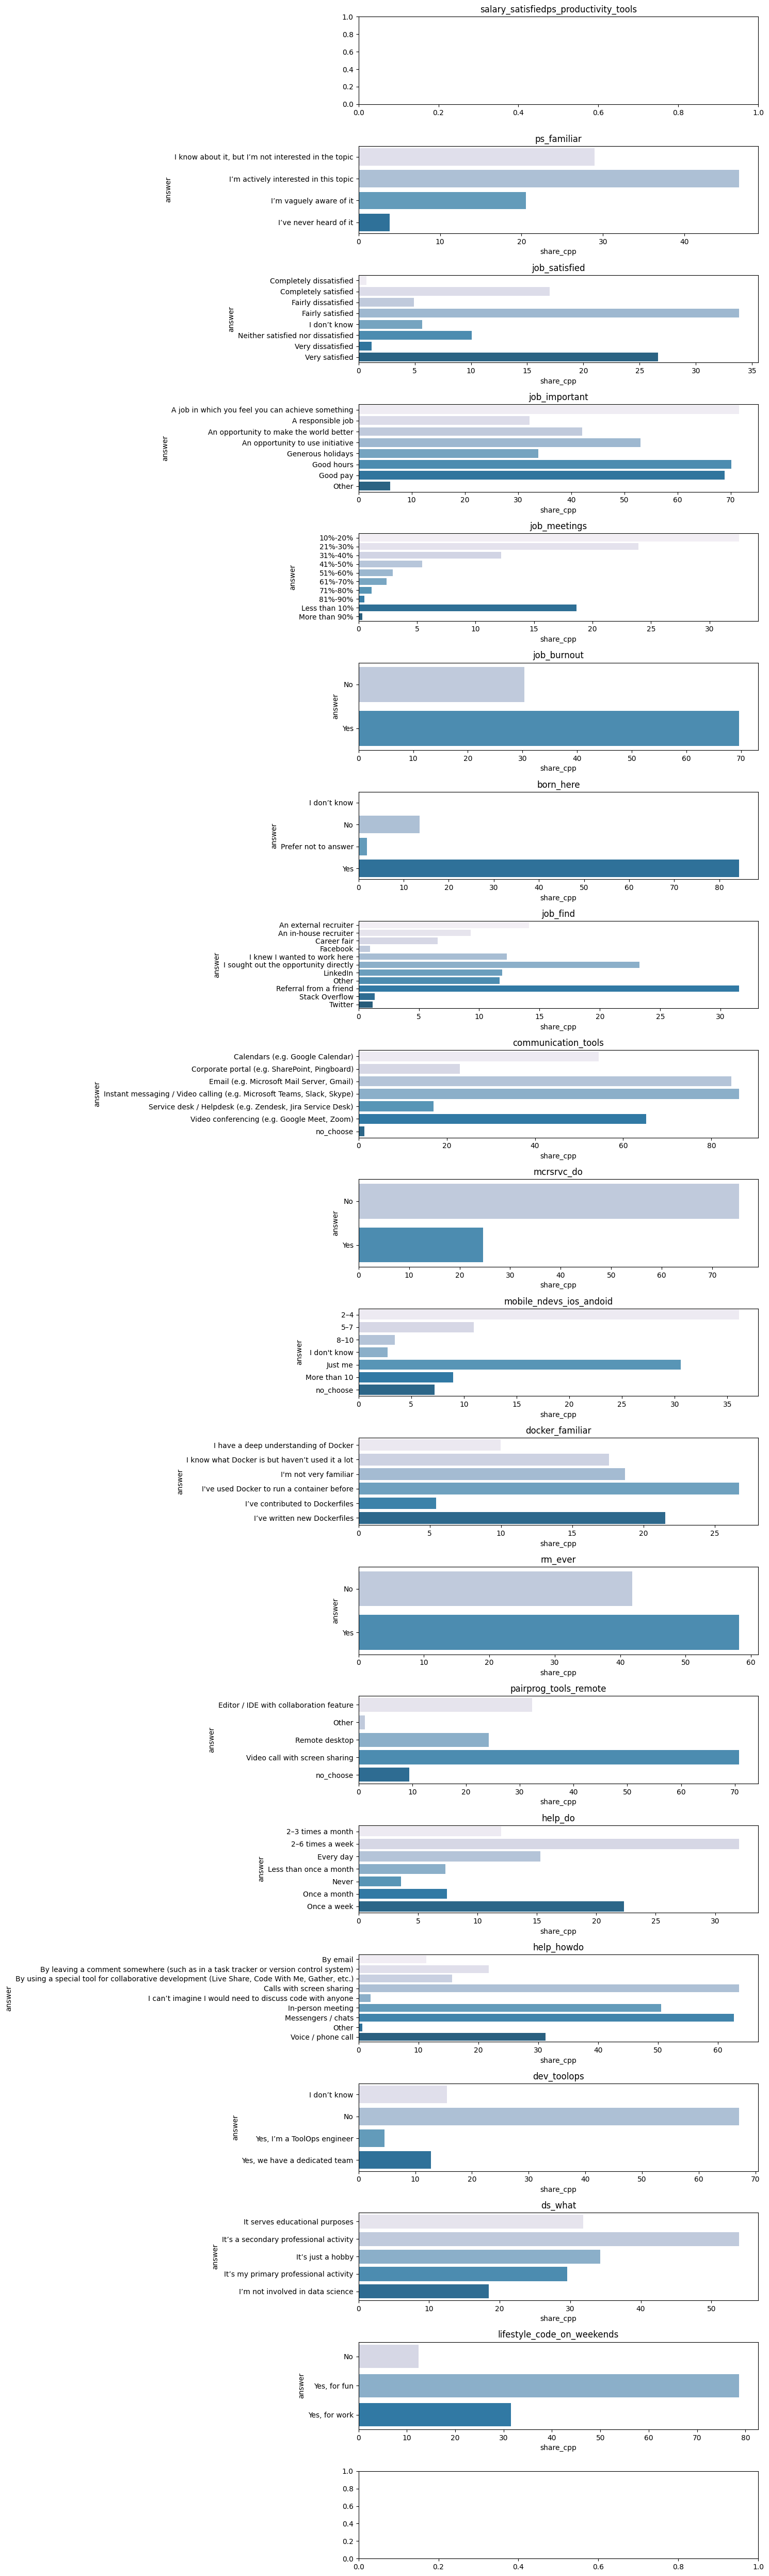

In [702]:
fig, axes = plt.subplots(20, 1, figsize=(15,50), squeeze=False)

for i, ax in zip(to_think_about, axes.ravel()):
    sns.barplot(data=to_think_about_df[to_think_about_df.tag == i], y='answer', x = 'share_cpp', alpha = 0.9, ax=ax, palette="PuBu")
    ax.set_title(i)
    # plt.xlabel(i, fontsize=12)
   
    plt.tight_layout() 
plt.show()

#### tools

In [704]:
tool_df = describe_programmers(narrow, tools, 'cnt_all_cpp_resp_on_question_23', 'cnt_all_resp_on_question_23', prolang_23)
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(tool_df.style \
            .background_gradient(cmap='RdPu', axis=0, subset = ['response_id', 'share_cpp', 'diff_in_share']) \
            .format('{:.1f}') \
            .map(lambda x: 'background-color: lightgray' if pd.isnull(x) else ''))

 **Notes**:
Respondents using C++:
* main agile framework tools: Scrum - 47.3, Kanban - 26.4

#### 23 VS 22

**Calculate significant differences in answers between 22 and 23 (chi square homogeneity/scipy.stats.chisquare, Fisher's exact test) Display questions where answers changed significantly**

In [708]:
# for info: count of c++ programmers response 
cnt_cpp_resp_23 = narrow[narrow.response_id.isin(prolang_23)].groupby('tag')[['response_id']].count()
cnt_cpp_resp_23.columns = ['cnt_all_cpp_resp_on_question_23_v2']
narrow = narrow.merge(cnt_cpp_resp_23, left_on = 'tag', right_index = True, how = 'left')

# 2022
cnt_cpp_resp_22 = narrow_22[narrow_22.response_id.isin(prolang_22)].groupby('tag')[['response_id']].count()
cnt_cpp_resp_22.columns = ['cnt_all_cpp_resp_on_question_22_v2']
narrow_22 = narrow_22.merge(cnt_cpp_resp_22, left_on = 'tag', right_index = True, how = 'left')

In [709]:
# count of c++ programmers unique response 2023
ch_23 = narrow[narrow.response_id.isin(prolang_23)].groupby(['tag', 'answer'])[['response_id', 'cnt_all_cpp_resp_on_question_23_v2']].agg({'response_id': 'count',
                                                                                    'cnt_all_cpp_resp_on_question_23_v2': 'min'})
ch_23['perc_of_answer_23'] = ch_23['response_id'] / ch_23['cnt_all_cpp_resp_on_question_23_v2']

In [710]:
# count of c++ programmers unique response 2022
ch_22 = narrow_22[narrow_22.response_id.isin(prolang_22)].groupby(['tag', 'answer'])[['response_id', 'cnt_all_cpp_resp_on_question_22_v2']].agg({'response_id': 'count',
                                                                                    'cnt_all_cpp_resp_on_question_22_v2': 'min'})
ch_22['perc_of_answer_22'] = ch_22['response_id'] / ch_22['cnt_all_cpp_resp_on_question_22_v2']

**If the p-value for chi-square is less than 0.05, then the data are significantly different**

In [712]:
ch_23.reset_index(inplace = True)
ch_22.reset_index(inplace = True)

In [714]:
ch_23['answer_new'] = ch_23.answer.apply(lambda x: x.replace(',', '').lower()[:40])
ch_22['answer_new'] = ch_22.answer.apply(lambda x: x.replace(',', '').lower()[:40])

In [715]:
# merge 2022 and 2023
ch = ch_23[['tag', 
            'answer_new', 
            'perc_of_answer_23']].merge(ch_22[['tag', 
                                               'answer_new', 
                                               'perc_of_answer_22']], left_on = ['tag', 
                                                                                 'answer_new'], right_on = ['tag', 
                                                                                                            'answer_new'], how = 'outer')

In [716]:
# ch.fillna(0, inplace = True)

In [717]:
ch['perc_of_answer_23'] = ch['perc_of_answer_23'] * 100
ch['perc_of_answer_22'] = ch['perc_of_answer_22'] * 100

In [718]:
ch_test = pd.DataFrame(columns = ['statistic', 'pvalue'])

In [719]:
ch[ch.tag == 'db']

,tag,answer_new,perc_of_answer_23,perc_of_answer_22
1061,db,amazon redshift,1.5301,1.1283
1062,db,cassandra,1.3076,1.2081
1063,db,clickhouse,0.7347,0.6623
1064,db,couchbase,0.5392,0.3863
1065,db,db2,0.9841,0.8831
1066,db,exasol,0.1415,0.0491
1067,db,h2,1.9143,2.0911
1068,db,hbase,0.4853,0.3495
1069,db,mariadb,7.1178,7.8003
1070,db,mongodb,11.0812,10.8113


In [720]:
for i in tag_common:
    try:
        ch_test.loc[i] = scipy.stats.chisquare(ch.loc[ch.tag == i, 'perc_of_answer_22'],
                                           ch.loc[ch.tag == i, 'perc_of_answer_23'])
    except:
        print(f'cannot calc {i}')

cannot calc lifestyle_personal_data
cannot calc lifestyle_stats


In [721]:
ch_test

,statistic,pvalue
secure_ci,NaN,NaN
devops_queues,0.0138,0.9064
learn_kind_of_content,0.0737,0.9948
cpp_guidelines_tools,NaN,NaN
doc_tools,NaN,NaN
...,...,...
php_async_libs,15.9828,0.0030
salary_satisfied,38.4667,0.0000
ds_orchestration,NaN,NaN
cpp_optimization,NaN,NaN


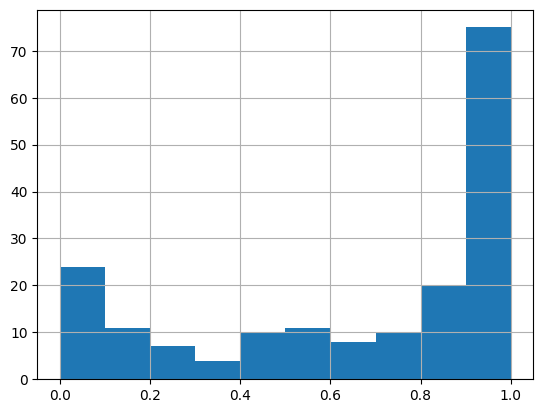

In [722]:
ch_test.pvalue.hist()
plt.show()

In [723]:
ch_test_result = ch_test.merge(cnt_resp_23, left_index = True, right_index = True, how = 'left').merge(cnt_resp_22, left_index = True, right_index = True, how = 'left')

In [724]:
ch_test_result

,statistic,pvalue,cnt_all_resp_on_question_23,cnt_all_resp_on_question_22
secure_ci,NaN,NaN,2251.0000,744.0000
devops_queues,0.0138,0.9064,5098.0000,4178.0000
learn_kind_of_content,0.0737,0.9948,7682.0000,3630.0000
cpp_guidelines_tools,NaN,NaN,2410.0000,2438.0000
doc_tools,NaN,NaN,2650.0000,3031.0000
...,...,...,...,...
php_async_libs,15.9828,0.0030,2248.0000,3737.0000
salary_satisfied,38.4667,0.0000,19296.0000,21665.0000
ds_orchestration,NaN,NaN,2894.0000,2771.0000
cpp_optimization,NaN,NaN,2408.0000,2431.0000


In [725]:
change_structure = ch_test_result[(ch_test_result.pvalue < 0.05) & (ch_test_result.cnt_all_resp_on_question_23 > 600)]
change_structure

,statistic,pvalue,cnt_all_resp_on_question_23,cnt_all_resp_on_question_22
secure_use,27.1213,0.0000,5035.0000,4185.0000
go_pls,16.2350,0.0003,1199.0000,603.0000
go_router,18.0073,0.0119,3346.0000,2040.0000
ds_mpp,21.7273,0.0054,2894.0000,1219.0000
pairprog_tools_remote,61.4466,0.0000,3155.0000,3927.0000
scala_3,6.2133,0.0448,1353.0000,361.0000
go_how,30.8905,0.0000,3383.0000,2097.0000
ruby_frameworks,56.6895,0.0000,965.0000,477.0000
scala_ide_additional,109.5358,0.0000,1354.0000,361.0000
go_code_size,17.0784,0.0169,3334.0000,1207.0000


In [726]:
ch['diff'] = ch['perc_of_answer_23'] - ch['perc_of_answer_22']

In [727]:
list_of_interest = ['secure_use', 'ds_mpp', 'pairprog_tools_remote', 'ruby_frameworks', 'salary_satisfied']

In [728]:
with pd.option_context('display.max_colwidth', None):
    display(tag[tag.shortname.isin(list_of_interest)])

,shortname,parent_shortname,question_title,type
226,ruby_frameworks,NaN,"What web development tools and / or frameworks do you regularly use, if any?",CHECKBOX
328,pairprog_tools_remote,NaN,What tools do you use for remote simultaneous collaborative development?,CHECKBOX
368,secure_use,NaN,Do you follow a secure software development life cycle?,RADIO
430,ds_mpp,NaN,Which of these MPP tools do you use?,CHECKBOX
460,salary_satisfied,NaN,How satisfied are you with your salary?,RADIO


In [729]:
for i in list_of_interest:
    display(ch[ch.tag == i].style \
            .background_gradient(cmap='RdPu', axis=0) \
            .map(lambda x: 'background-color: lightgray' if pd.isnull(x) else ''))

,tag,answer_new,perc_of_answer_23,perc_of_answer_22,diff
5016,secure_use,no,45.031905,70.942111,-25.910206
5017,secure_use,yes,54.968095,29.057889,25.910206


,tag,answer_new,perc_of_answer_23,perc_of_answer_22,diff
1670,ds_mpp,azure data explorer,8.830275,9.779180,-0.948905
1671,ds_mpp,azure sql data warehouse,7.568807,7.570978,-0.002171
1672,ds_mpp,bigquery,9.288991,8.517350,0.771641
1673,ds_mpp,clickhouse,2.637615,3.470032,-0.832417
1674,ds_mpp,greenplum,2.752294,0.315457,2.436836
1675,ds_mpp,no_choose,57.224771,58.990536,-1.765766
1676,ds_mpp,other,0.114679,1.577287,-1.462608
1677,ds_mpp,redshift,8.256881,7.570978,0.685903
1678,ds_mpp,spanner,3.325688,2.208202,1.117486


,tag,answer_new,perc_of_answer_23,perc_of_answer_22,diff
3626,pairprog_tools_remote,editor / ide with collaboration feature,23.427332,18.394024,5.033308
3627,pairprog_tools_remote,no_choose,6.832972,26.610644,-19.777672
3628,pairprog_tools_remote,other,0.867679,0.653595,0.214084
3629,pairprog_tools_remote,remote desktop,17.570499,13.725490,3.845009
3630,pairprog_tools_remote,video call with screen sharing,51.301518,40.616246,10.685272


,tag,answer_new,perc_of_answer_23,perc_of_answer_22,diff
4549,ruby_frameworks,grape,4.526749,6.976744,-2.449995
4550,ruby_frameworks,no_choose,32.510288,6.976744,25.533544
4551,ruby_frameworks,other,6.995885,2.325581,4.670303
4552,ruby_frameworks,rack,5.349794,17.441860,-12.092066
4553,ruby_frameworks,ruby on rails,42.386831,55.813953,-13.427122
4554,ruby_frameworks,sinatra,8.230453,10.465116,-2.234664


,tag,answer_new,perc_of_answer_23,perc_of_answer_22,diff
4799,salary_satisfied,completely dissatisfied,5.074116,4.294346,0.779770
4800,salary_satisfied,completely satisfied,8.266819,8.588692,-0.321874
4801,salary_satisfied,mostly dissatisfied,7.810718,5.848079,1.962639
4802,salary_satisfied,mostly satisfied,24.885975,21.514890,3.371085
4803,salary_satisfied,prefer not to answer,5.159635,18.795857,-13.636222
4804,salary_satisfied,rather dissatisfied,18.871152,14.846785,4.024367
4805,salary_satisfied,rather satisfied,29.931585,26.111351,3.820234


In [848]:
#cpp
# with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
#     display(tag)

<a class="anchor" id="q4"></a>
# 4. Что пишут пользователи CLion на StackOverflow, с какими трудностями они сталкиваются при использовании Cn

In [850]:
import nltk
import re
import string
from nltk.corpus import stopwords
import gensim
from gensim import corpora
import pyLDAvis.gensim
nltk.download('averaged_perceptron_tagger')
import json

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\avpodborodnikova\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [851]:
sof = pd.read_csv('data/tags.csv')

In [853]:
sof.shape

(2339, 23)

In [855]:
sof.CreationDate.min(), sof.CreationDate.max()

('2014-09-12 10:40:46', '2023-01-26 11:40:30')

## Short preAnalysis

**look at the posts with the biggest ViewCount**

In [858]:
sof['ViewCount_bin'] = pd.cut(sof['ViewCount'], bins = 10, precision = 0).astype('str')

In [860]:
temp = sof.groupby(['ViewCount_bin'])[['Id', 'ViewCount']].agg({'Id': 'count',
                                                  'ViewCount': 'mean'})
temp.sort_values('ViewCount')

,Id,ViewCount
ViewCount_bin,,
"(-172.0, 18195.0]",2268,1870.3430
"(18195.0, 36379.0]",46,25161.9348
"(36379.0, 54564.0]",16,41807.0625
"(54564.0, 72748.0]",2,64035.5000
"(72748.0, 90933.0]",2,79731.0000
"(109118.0, 127302.0]",2,118830.5000
"(127302.0, 145487.0]",2,139820.5000
"(163671.0, 181856.0]",1,181856.0000


**Note**:
5 posts with views over 100,000, let's see what these posts are about

In [863]:
with pd.option_context('display.max_colwidth', None):
    display(sof.sort_values('ViewCount')[['CreationDate', 
                                          'Title', 
                                          'ViewCount', 
                                          'AnswerCount',
                                          'CommentCount',
                                          'LastActivityDate',
                                         'ClosedDate']].tail(7))

,CreationDate,Title,ViewCount,AnswerCount,CommentCount,LastActivityDate,ClosedDate
718,2015-05-14 10:36:39,How to configure CLion IDE for Qt Framework?,76348,6,3,2020-12-25 19:18:20,NaN
482,2015-02-27 09:16:38,How to include external library (boost) into CLion C++ project with CMake?,83114,3,3,2020-06-07 20:58:12,NaN
885,2018-01-09 01:00:22,"CMake was unable to find a build program corresponding to ""Unix Makefiles""",116215,1,3,2023-07-12 16:42:10,2018-01-09 14:47:00
164,2014-11-13 21:09:44,Using local makefile for CLion instead of CMake,121446,6,0,2022-09-19 06:45:58,NaN
102,2017-09-15 18:42:44,"In CLion, header only library: file ""does not belong to any project target, code insight features might not work properly""",138854,5,0,2023-05-11 02:24:48,NaN
1901,2017-05-04 02:32:04,CMake - Creating a static library,140787,4,0,2023-09-18 11:45:35,NaN
1105,2015-10-21 19:07:27,How do I set up CLion to compile and run?,181856,3,1,2022-12-24 05:50:37,NaN


**How posts appeared over time**

In [867]:
sof['CreationDate'] = pd.to_datetime(sof['CreationDate'])

In [869]:
# table with aggregation by months (price descriptive statistic)
post_month = sof[['CreationDate', 'Id']].resample('ME', on = 'CreationDate').agg({'Id': 'count'})

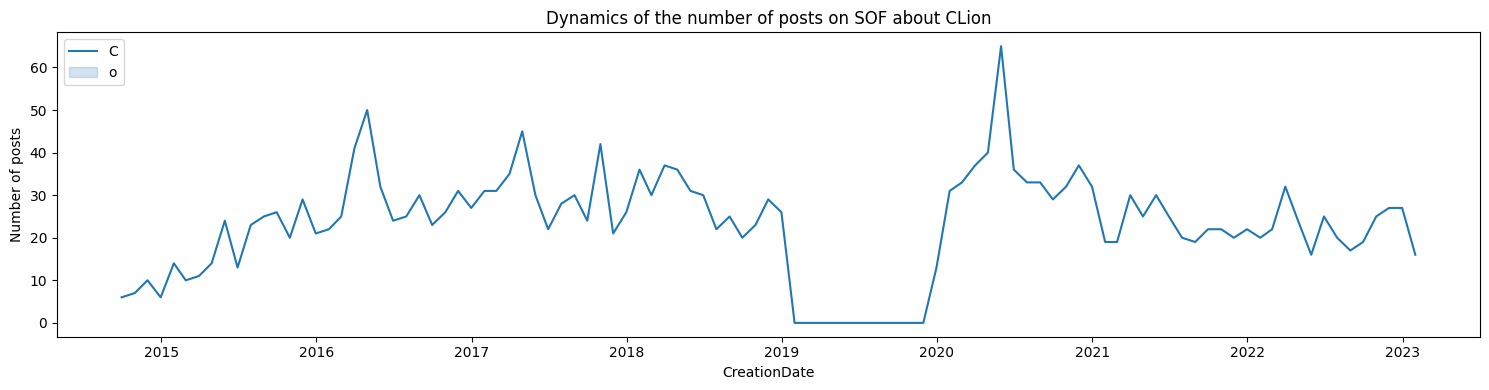

In [870]:
# plot descriptive statistics of price by month
plt.figure(figsize = (15, 4))

sns.lineplot(post_month['Id'])
plt.ylabel('Number of posts')
plt.title('Dynamics of the number of posts on SOF about CLion')
plt.legend('Сount', loc = 'upper left')

plt.tight_layout()
plt.show()

In [355]:
post_month[post_month.Id > 40]

,Id
CreationDate,
2016-03-31,41
2016-04-30,50
2017-04-30,45
2017-10-31,42
2020-05-31,65


**Note**:

* In March 2016, in May 2020, there are visible spikes in the number of posts.
* In 2019, there is no information on posts in the database, I assume that either the tags were changed, or it is not pulled from the data base.
* Recently (late 2022, early 2023), the number of posts per month is at the level of 15-20

**The latest issues**

In [516]:
with pd.option_context('display.max_colwidth', None):
    display(sof.sort_values('CreationDate')[['CreationDate', 
                                          'Title', 
                                          'ViewCount', 
                                          'AnswerCount',
                                          'CommentCount',
                                          'LastActivityDate',
                                         'ClosedDate']].tail(4))

,CreationDate,Title,ViewCount,AnswerCount,CommentCount,LastActivityDate,ClosedDate
2332,2023-01-20 15:39:03,Build problems with test Project trying to use zeromq,781,1,1,2023-01-21 09:54:29,NaN
2333,2023-01-21 19:50:08,Adding include paths to a CLion Makefile project,1718,1,0,2023-01-22 03:21:26,NaN
2334,2023-01-22 03:47:05,CMake is unable to locate include files,449,1,9,2023-01-22 12:44:09,NaN
2338,2023-01-26 11:40:30,"Linker error with Libtorch, Cmake and CLion",376,1,4,2023-01-26 19:23:20,NaN


**Posts with the most comments**

In [360]:
with pd.option_context('display.max_colwidth', None):
    display(sof.sort_values('CommentCount')[['CreationDate', 
                                          'Title', 
                                          'ViewCount', 
                                          'AnswerCount',
                                          'CommentCount',
                                          'LastActivityDate',
                                         'ClosedDate']].tail(7))

,CreationDate,Title,ViewCount,AnswerCount,CommentCount,LastActivityDate,ClosedDate
809,2020-06-27 19:21:25,C++ Comma Separated Input Array Code Exiting Prematurely,412,3,20,2020-06-27 20:37:54,NaN
1608,2017-01-29 01:48:45,Spurious type error with variadic template and tuple in CLion?,286,0,20,2017-01-29 02:20:17,NaN
477,2017-11-01 15:22:48,Is the default return type in C++11 long?,392,2,20,2017-11-01 15:55:57,2017-11-01 15:48:21
108,2016-03-28 19:59:46,Output for CLion IDE sometimes cuts off when executing a program,2702,1,20,2017-12-06 23:05:12,NaN
554,2020-05-01 21:31:46,How to add MPICH library to CLion project?,1021,0,22,2020-05-03 01:45:11,NaN
92,2016-03-28 00:47:15,Reading file into a struct sometimes stops for no reason,63,2,22,2016-03-31 22:58:35,NaN
986,2015-09-04 18:59:37,Can't open a file with unicode chars in the file name using CLion,547,2,25,2015-09-06 15:43:33,NaN


## LDA

Let's analyze the topics of the posts in a more general way. Let's highlight the main topics of the posts using LDA model.

**Note**: analyze English only

In [363]:
post = pd.DataFrame(sof.Body)

In [364]:
# leave only letters, all lowercase
clean_post = pd.DataFrame(data = post['Body'].apply(lambda x: re.sub("[^a-zA-Z]"," ", x.lower())))
clean_post.columns = ['postText']

In [365]:
clean_post.head()

,postText
0,p strong tldr strong p p in lldb ...
1,p i have tried in two ides namely clion and x...
2,p i am trying to link to a shared library usi...
3,p i am running linux debian and i want to i...
4,p is it possible to change the options in cli...


### Form Bigrams & Trigrams

In [367]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in clean_post.postText])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [368]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in clean_post.postText])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

In [369]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [370]:
bigram_pmi

,bigram,pmi
0,"(laser, na)",12.9629
1,"(na, stacje)",12.9629
2,"(skipping, incompatible)",12.9158
3,"(relocation, truncated)",12.8695
4,"(permission, denied)",12.3566
...,...,...
1329,"(the, a)",-1.7913
1330,"(code, the)",-1.7930
1331,"(cmake, i)",-1.8151
1332,"(p, c)",-2.3634


In [371]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [372]:
# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stopwords or bigram[1] in stopwords:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

In [373]:
# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stopwords or trigram[-1] in stopwords or trigram[1] in stopwords:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True 

In [374]:
bigram_pmi

,bigram,pmi
0,"(laser, na)",12.9629
1,"(na, stacje)",12.9629
2,"(skipping, incompatible)",12.9158
3,"(relocation, truncated)",12.8695
4,"(permission, denied)",12.3566
...,...,...
1329,"(the, a)",-1.7913
1330,"(code, the)",-1.7930
1331,"(cmake, i)",-1.8151
1332,"(p, c)",-2.3634


In [375]:
stopwords = nltk.corpus.stopwords.words('english')

In [376]:
# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
# choose top 500 ngrams in this case ranked by PMI that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:500]

filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > 5, axis = 1)][:500]


bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [377]:
# examples of bigrams
bigrams[:10]

['laser na',
 'relocation truncated',
 'permission denied',
 'lnk unresolved',
 'icmi demo',
 'none eabi',
 'configuring incomplete',
 'prettyprint override',
 'compilation terminated',
 'http tcpip']

In [378]:
# examples of trigrams
trigrams[:10]

['laser na stacje',
 'arm none eabi',
 'lnk unresolved external',
 'incomplete errors occurred',
 'community vc tools',
 'openssl config archs',
 'configuring incomplete errors',
 'cidr execution debugger',
 'studio community vc',
 'unresolved external symbol']

In [379]:
# Concatenate n-grams
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

In [380]:
post_w_ngrams = clean_post.copy()

In [381]:
post_w_ngrams.postText = post_w_ngrams.postText.map(lambda x: replace_ngram(x))

In [382]:
# tokenize post + remove stop words + remove names + remove words with less than 2 characters
post_w_ngrams = post_w_ngrams.postText.map(lambda x: [word for word in x.split()\
                                                 if word not in stopwords
                                                              and len(word) > 2])

### Filter for only nouns and verbs

In [384]:
#Filter for only nouns
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    # filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

In [385]:
final_post = post_w_ngrams.map(noun_only)

In [386]:
final_post = post_w_ngrams.copy()

In [387]:
final_post

0       [strong, tldr, strong, lldb, code, getarraytyp...
1       [tried, two, ides, namely, clion, xcode, get, ...
2       [trying, link, shared, library, using, cmake, ...
3       [running, linux, debian, want, include, header...
4       [possible, change, options, clion, variables, ...
                              ...                        
2334    [href, https, sstatic_net, lnx, png, rel, nofo...
2335    [trying, test, parts, code, wrote, following, ...
2336    [directory, called, code, question, code, foll...
2337    [tryign, enter, poor, name, non, numeric, alph...
2338    [starting, libtorch, seem, run, rather, seriou...
Name: postText, Length: 2339, dtype: object

### LDA Model

In [389]:
dictionary = corpora.Dictionary(final_post)

In [390]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_post]

In [391]:
coherence = []
for k in range(5,20):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=40,\
                   iterations=150, chunksize = 800, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_post,\
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19


In [392]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

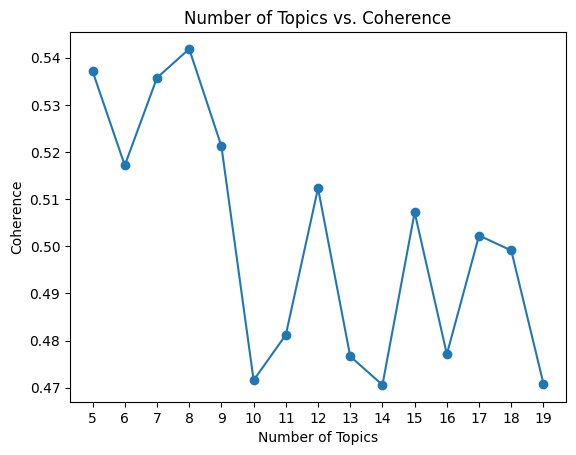

In [393]:
plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

In [394]:
#first model: fewer topics**
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=5, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

In [395]:
Lda2 = gensim.models.ldamodel.LdaModel
ldamodel2 = Lda2(doc_term_matrix, num_topics=23, id2word = dictionary, passes=20,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

In [396]:
# To show initial topics
# ldamodel.show_topics(15, num_words=10, formatted=False)

In [397]:
# To show initial topics
# ldamodel2.show_topics(23, num_words=10, formatted=False)

#### V1

In [399]:
topic_data_1 =  pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data_1)

In [400]:
all_topics_1 = {}
num_terms = 9 # Adjust number of words to represent each topic
lambd = 0.6 # Adjust this accordingly based on tuning above
for i in range(1,6): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data_1.topic_info[topic_data_1.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics_1['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

In [401]:
pd.DataFrame(all_topics_1).T

,0,1,2,3,4,5,6,7,8
Topic 1,code,pre,project,cmake,clion,sdl,library,file,include
Topic 2,code,int,pre,return,amp,cout,string,size,printf
Topic 3,cmakefiles,mingw,opencv,error,clionprojects,users,make_exe,bin,cmtc
Topic 4,quot,png,sstatic_net,https,img_src,alt,rel,nofollow_noreferrer,href
Topic 5,boost,std,glfw,opengl,glew,mysql,undefined_reference,detail,log


#### V2

In [403]:
topic_data_2 =  pyLDAvis.gensim.prepare(ldamodel2, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data_2)

In [404]:
all_topics_2 = {}
num_terms = 7 # Adjust number of words to represent each topic
lambd = 0.6 # Adjust this accordingly based on tuning above
for i in range(1,24): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data_2.topic_info[topic_data_2.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics_2['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

In [405]:
pd.DataFrame(all_topics_2).T

,0,1,2,3,4,5,6
Topic 1,https,clion,sstatic_net,png,href,rel,code
Topic 2,code,project,pre,src,library,cmake,include
Topic 3,cmakefiles,error,mingw,cmake,make_exe,users,dir
Topic 4,int,std,cout,endl,size,string,return
Topic 5,code,strong,pre,viewer,igl,curl,pqxx
Topic 6,code,opencv,pre,context,clang,main_cpp,mat
Topic 7,quot,debug,rust_manual,rlib_quot,deps,documents,target
Topic 8,cmake,python,mpi,openmp,bin,laser_na_stacje_v,esp
Topic 9,printf,quot,int,cryptopp,char,scanf,main
Topic 10,code,pre,foo,test,library,framework,attempt


**Note**: Need to dig deeper into the topics to understand what the key words have in common. Discuss with those close to the topic

**What else could be done**:
* use a different model
* choose different learning parameters
* analyze not only English
* deal with the lack of posts in 2019